In [103]:
#Libraries
import pandas as pd
import numpy as np
from pathlib import Path #this library minimizes issues when using paths in Mac
import os
#pip install dataprep --user
from dataprep.eda import create_report
import re
import datetime
import random

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import streamlit as st

from scipy.stats.mstats import winsorize
import scipy.stats as stats
from scipy.cluster.hierarchy import linkage, dendrogram
import math

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.formula.api import ols

from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,explained_variance_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (train_test_split,GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, learning_curve)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
import country_converter as coco


#import warnings

#warnings.filterwarnings('ignore')
#warnings.simplefilter('ignore')

pd.set_option('display.max_rows', None)

In [2]:
#pip freeze > requirements.txt

In [3]:
#Seaborn Context
sns.set_theme(style='whitegrid', context='paper', palette='deep')
#plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1));
#sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot
#plt.figure(figsize=(9, 5)) 

In [4]:
#List of Folders
prod_folder = Path("data/Value_of_Production_E_All_Data")
pop_folder = Path("data/Population_E_All_Data")

In [5]:
def clean_fao_df(df,element, drop_columns,value_column):
    #remove flags
    df = df[df.columns.drop(list(df.filter(regex='.*?F')))]
    #filter by element
    df = df[df["Element"]==element]
    #drop columns
    df = df[df.columns.drop(drop_columns)]
    #wide_to_long by year
    df=pd.wide_to_long(df, stubnames='Y', i=['Area', 'Item'], j='Year').reset_index()
    df.rename(columns = {'Y':value_column}, inplace = True)
    return df

In [6]:
prod_df = pd.read_csv(prod_folder /"Value_of_Production_E_All_Data.csv", encoding = 'unicode_escape')
prod_df.head()
prod_df['Area'][prod_df['Area']== 'China, Taiwan Province of']='Taiwan';

C:\Users\blancc2\AppData\Local\Temp\ipykernel_13860\526708962.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_df['Area'][prod_df['Area']== 'China, Taiwan Province of']='Taiwan';


In [7]:
drop_columns = ["Area Code (M49)", "Area Code", "Item Code","Item Code (CPC)", "Element", "Element Code", "Unit"]
prod_df = clean_fao_df(prod_df, 'Gross Production Value (constant 2014-2016 thousand I$)', drop_columns, 'Total_Prod' )

In [8]:
#Chose 2019 as 2020 could be impacted by Covid
#https://www.nature.com/articles/s41599-022-01080-0
#The study concluded that interruptions in agricultural food supply as a result of the pandemic impacted supply and demand shocks with negative impacts on all the four pillars of food security.
prod19_df=prod_df[prod_df["Year"]==2019]
prod19_df = prod19_df[prod19_df.columns.drop(['Year'])]

In [9]:
pop_df = pd.read_csv(pop_folder /"Population_E_All_Data_NOFLAG.csv", encoding = 'unicode_escape')

In [10]:
drop_columns = ["Area Code (M49)", "Area Code", "Item Code", "Element", "Element Code", "Unit"]
pop_df = clean_fao_df(pop_df, 'Total Population - Both sexes', drop_columns, 'Total_Population' )
pop19_df=pop_df[pop_df["Year"]==2019]
pop19_df = pop19_df[pop19_df.columns.drop(['Item', 'Year'])]
pop19_df.head()

Area  Total_Population
69      Afghanistan         37769.499
220         Albania          2873.883
371         Algeria         42705.368
522  American Samoa            47.321
673         Andorra            76.343

In [11]:
prod19_df=prod19_df.merge(pop19_df, how='left', on='Area') 

In [12]:
prod19_df['Prod_Capita']=prod19_df['Total_Prod']/prod19_df['Total_Population']
prod19_df = prod19_df[prod19_df.columns.drop(['Total_Prod', 'Total_Population'])]

In [13]:
prod19_df.head()

Area                                               Item  Prod_Capita
0  Afghanistan                                  Almonds, in shell     5.114391
1  Afghanistan  Anise, badian, coriander, cumin, caraway, fenn...     1.042958
2  Afghanistan                                             Apples     3.128265
3  Afghanistan                                           Apricots     2.805306
4  Afghanistan                                             Barley     0.637446

In [14]:
prod19_df=prod19_df.pivot(index='Area', columns='Item', values='Prod_Capita')

In [15]:
prod19_df=prod19_df.reset_index(level=0)

In [16]:
#Noticed that there are Areas that are not countries, but groups of them ("World", "Americas", etc.)
#Downloaded the groups file to remove them at once
pop_group_df = pd.read_csv(pop_folder /"Population_E_All_Area_Groups_NOFLAG.csv", encoding = 'unicode_escape')

In [17]:
prod19_df = prod19_df[~prod19_df['Area'].isin(pop_group_df['Area'].unique())] 

In [18]:
prod19_df.head()

Item                 Area  Abaca, manila hemp, raw  Agave fibres, raw, n.e.c.  \
0             Afghanistan                      NaN                        NaN   
2                 Albania                      NaN                        NaN   
3                 Algeria                      NaN                        NaN   
5                  Angola                      NaN                        NaN   
6     Antigua and Barbuda                      NaN                        NaN   

Item  Agriculture  Almonds, in shell  \
0      174.078401           5.114391   
2      736.821228                NaN   
3      364.737754           8.573185   
5      190.689824                NaN   
6       92.230533                NaN   

Item  Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw  \
0                                              1.042958                           
2                                                   NaN                           
3                                                   NaN                           
5                                                   NaN                           
6                                                   NaN                           

Item     Apples  Apricots  Areca nuts  Artichokes  ...  \
0      3.128265  2.805306         NaN         NaN  ...   
2     17.398412  1.389409         NaN         NaN  ...   
3      6.176483  4.012376         NaN    1.941981  ...   
5           NaN       NaN         NaN         NaN  ...   
6           NaN       NaN         NaN         NaN  ...   

Item  Unmanufactured tobacco  Vanilla, raw  Vegetables Primary  \
0                        NaN           NaN           12.133944   
2                   1.093294           NaN          151.655095   
3                   0.795263           NaN           73.969390   
5                   0.201152           NaN            6.316054   
6                        NaN           NaN            6.622013   

Item  Vegetables and Fruit Primary   Vetches  Walnuts, in shell  Watermelons  \
0                        62.010804       NaN            1.22771     5.202902   
2                       307.200398  0.251924                NaN    20.965711   
3                       159.457167  0.000679                NaN    11.989523   
5                        63.896623       NaN                NaN          NaN   
6                        64.928298       NaN                NaN          NaN   

Item      Wheat      Yams  Yautia  
0     30.662361       NaN     NaN  
2     19.218945       NaN     NaN  
3     21.499944       NaN     NaN  
5      0.021667       NaN     NaN  
6           NaN  0.390807     NaN  

[5 rows x 200 columns]

In [19]:
cols=['Area','Cereals, Total','Fruit Primary',
                                    'Meat indigenous, total','Milk, Total',
                                    'Non Food','Roots and Tubers, Total',
                                    'Sugar Crops Primary','Vegetables Primary']
prod19_df=prod19_df[cols]

In [20]:
print("There are",prod19_df.shape[1]-1, "products and", prod19_df.shape[0], "countries.\n")
print("The Products with most null values are:")
print(prod19_df.isnull().sum().sort_values(ascending=False).head(5).to_string())


There are 8 products and 211 countries.

The Products with most null values are:
Item
Sugar Crops Primary    78
Non Food               37
Cereals, Total         32
Milk, Total            25
Vegetables Primary     17


In [21]:
#Drop countries with more than 20% of values null
prod19_df.dropna(thresh=(prod19_df.shape[1]+1)*4/5, inplace=True)

In [22]:
#Check: 
#print(prod19_df.isna().sum(axis=1).sort_values(ascending=False).head(20).to_string())

In [23]:
prod19_df.describe().T

count        mean         std       min        25%  \
Item                                                                          
Cereals, Total           170.0   81.012707   99.203894  0.017310  14.767071   
Fruit Primary            172.0   64.089820   70.254737  0.236664  20.397495   
Meat indigenous, total   172.0  124.635504  153.873031  6.744110  37.009241   
Milk, Total              172.0   71.341294  160.471578  0.009117   6.868545   
Non Food                 169.0   11.475760   23.502602  0.011473   1.042979   
Roots and Tubers, Total  172.0   27.498902   33.527964  0.113877   7.737667   
Sugar Crops Primary      132.0   16.301546   33.663108  0.004719   1.090008   
Vegetables Primary       172.0   33.320792   34.791779  1.864043  10.519419   

                               50%         75%          max  
Item                                                         
Cereals, Total           42.634996  100.578706   415.269755  
Fruit Primary            44.002380   83.219309   498.016533  
Meat indigenous, total   80.980446  148.919178  1143.134127  
Milk, Total              28.552198   92.120420  1828.248606  
Non Food                  4.457556   10.876712   230.533608  
Roots and Tubers, Total  15.264346   32.817029   178.781430  
Sugar Crops Primary       5.530126   14.878528   220.159147  
Vegetables Primary       18.891565   45.651559   176.513701

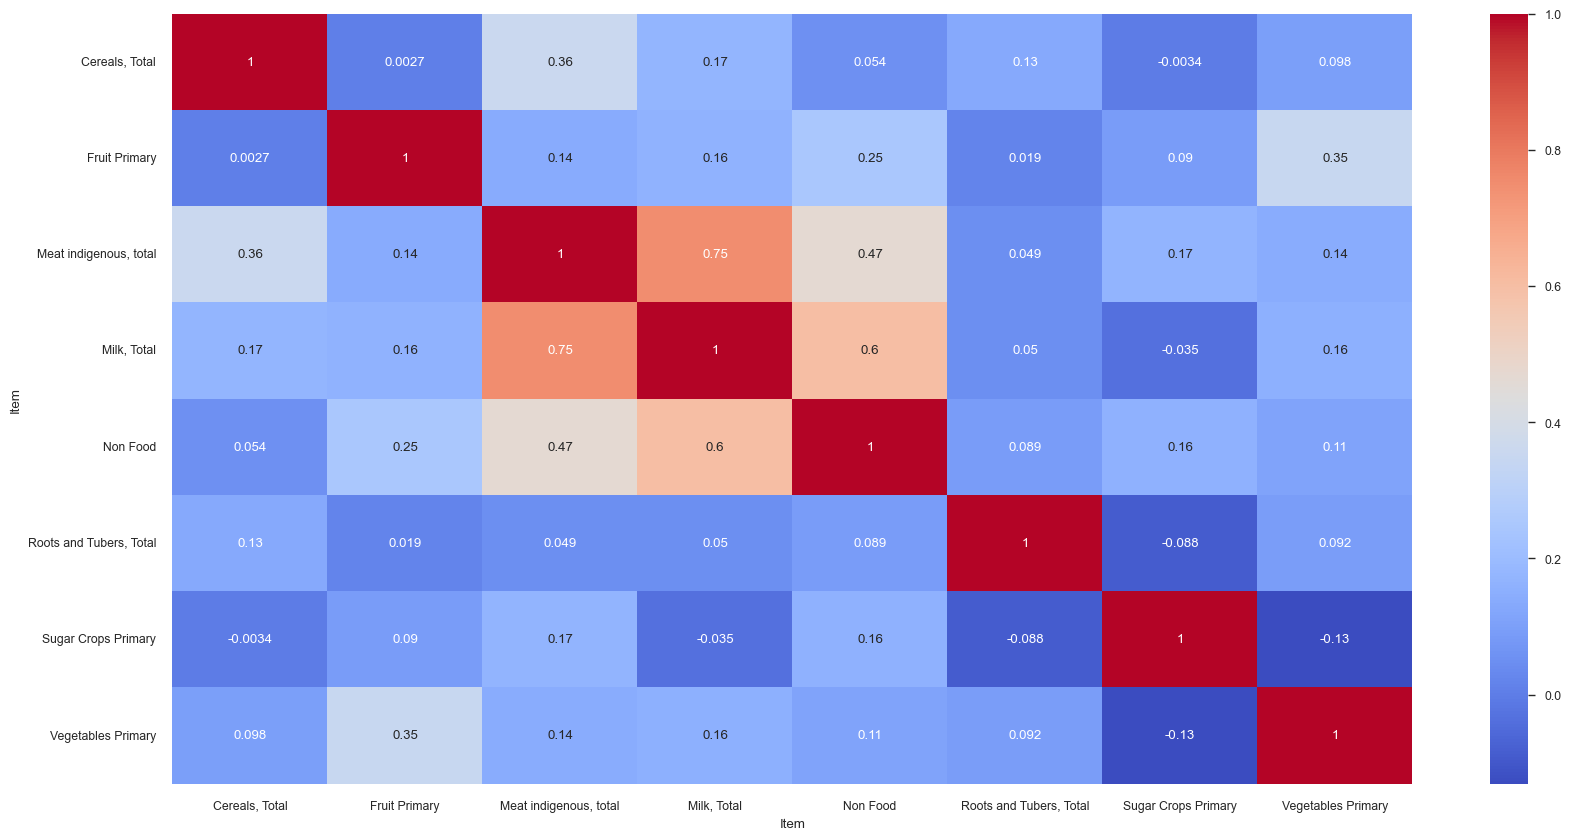

In [24]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(prod19_df.corr(),annot = True, cmap='coolwarm')
plt.show()

In [25]:
#featurewiz does not work for clustering or unsupervised problems
#pip install featurewiz --user

In [26]:
prod19_df.fillna(0, inplace=True)

In [27]:
prod19_df.set_index('Area', inplace=True)
prod19_df.head()

Item         Cereals, Total  Fruit Primary  Meat indigenous, total  \
Area                                                                 
Afghanistan       36.263282      49.876860               30.440250   
Albania           49.112995     155.545650               96.876247   
Algeria           29.452386      85.487778               64.256817   
Angola            18.371780      57.580569               30.352553   
Argentina        399.957873     106.359028              437.902230   

Item         Milk, Total   Non Food  Roots and Tubers, Total  \
Area                                                           
Afghanistan    24.313719   2.170455                 6.103549   
Albania       167.844690  17.509759                22.699254   
Algeria        35.373773   3.959409                29.420493   
Angola          2.807108   1.636325                54.670691   
Argentina      96.165605  26.035053                15.776663   

Item         Sugar Crops Primary  Vegetables Primary  
Area                                                  
Afghanistan             0.054991           12.133944  
Albania                 0.503500          151.655095  
Algeria                 0.000000           73.969390  
Angola                  1.040472            6.316054  
Argentina              18.432147           30.400876

In [28]:
#https://www.kaggle.com/code/emilytries/clustering-and-feature-selection
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in prod19_df.columns:
    replace_with_thresholds(prod19_df, col)

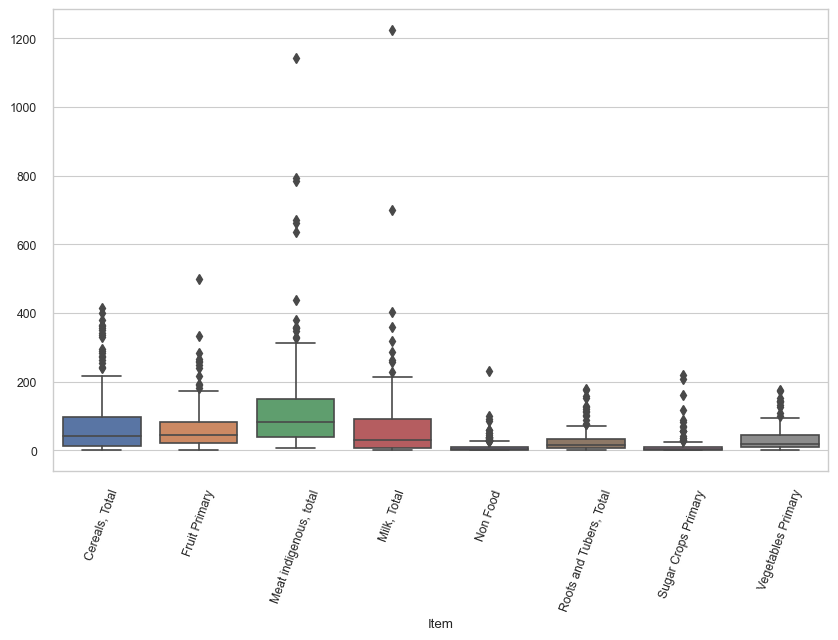

In [29]:
plt.figure(figsize=(10,6))
sns.boxplot(data=prod19_df)
plt.xticks(rotation=70)
plt.show()

In [30]:
def df_minmax(df):
    # Min Max Scaler
    sc = MinMaxScaler((0, 1))
    df_trans = sc.fit_transform(df)
    return pd.DataFrame(df_trans, columns=df.columns, index=df.index)

In [31]:
data19_scaled = df_minmax(prod19_df)
data19_scaled.head()

Item         Cereals, Total  Fruit Primary  Meat indigenous, total  \
Area                                                                 
Afghanistan        0.087325       0.099723                0.020852   
Albania            0.118268       0.312003                0.079314   
Algeria            0.070924       0.171263                0.050610   
Angola             0.044241       0.115199                0.020775   
Argentina          0.963128       0.213191                0.379410   

Item         Milk, Total  Non Food  Roots and Tubers, Total  \
Area                                                          
Afghanistan     0.019863  0.009415                 0.033524   
Albania         0.137164  0.075953                 0.126410   
Algeria         0.028902  0.017175                 0.164029   
Angola          0.002287  0.007098                 0.305354   
Argentina       0.078584  0.112934                 0.087664   

Item         Sugar Crops Primary  Vegetables Primary  
Area                                                  
Afghanistan             0.000250            0.058803  
Albania                 0.002287            0.857666  
Algeria                 0.000000            0.412857  
Angola                  0.004726            0.025491  
Argentina               0.083722            0.163395

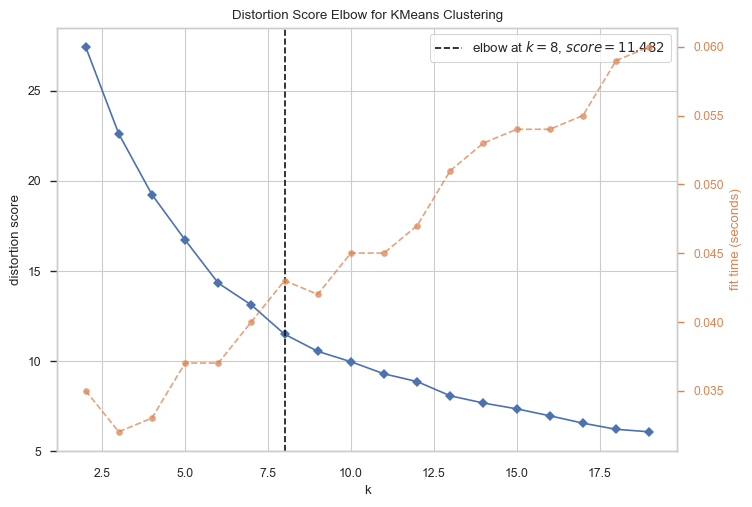

In [32]:
# KMeans Clustering
#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
#kmeans = KMeans()
#ssd = []
#K = range(1, 44)

#for k in K:
#    kmeans = KMeans(n_clusters=k).fit(data_scaled)
#    ssd.append(kmeans.inertia_)

#ssd

#plt.plot(K, ssd, "bx-")
#plt.xlabel("Distance Residual Sums for K Values (WCSS)")
#plt.title("Elbow Method for Optimum Number of Clusters")
#plt.show()

kmeans = KMeans()
fig = KElbowVisualizer(kmeans, k=(2, 20))
fig.fit(data19_scaled)
fig.show();

In [33]:
n_clusters=fig.elbow_value_
kmeans = KMeans(n_clusters).fit(data19_scaled)
clusters = kmeans.labels_

#pd.DataFrame({"Customers": prod19_df.index, "Clusters": clusters})
prod19_df["cluster_no"] = clusters
prod19_df.head()

Item         Cereals, Total  Fruit Primary  Meat indigenous, total  \
Area                                                                 
Afghanistan       36.263282      49.876860               30.440250   
Albania           49.112995     155.545650               96.876247   
Algeria           29.452386      85.487778               64.256817   
Angola            18.371780      57.580569               30.352553   
Argentina        399.957873     106.359028              437.902230   

Item         Milk, Total   Non Food  Roots and Tubers, Total  \
Area                                                           
Afghanistan    24.313719   2.170455                 6.103549   
Albania       167.844690  17.509759                22.699254   
Algeria        35.373773   3.959409                29.420493   
Angola          2.807108   1.636325                54.670691   
Argentina      96.165605  26.035053                15.776663   

Item         Sugar Crops Primary  Vegetables Primary  cluster_no  
Area                                                              
Afghanistan             0.054991           12.133944           3  
Albania                 0.503500          151.655095           5  
Algeria                 0.000000           73.969390           0  
Angola                  1.040472            6.316054           3  
Argentina              18.432147           30.400876           1

In [34]:
#prod19_df["cluster_no"] = prod19_df["cluster_no"] + 1
prod19_df.groupby("cluster_no").agg({"cluster_no": "count"})

Item        cluster_no
cluster_no            
0                   30
1                   20
2                   20
3                   78
4                    5
5                    9
6                    1
7                    9

In [35]:
prod19_df.groupby("cluster_no").agg(np.mean)

Item        Cereals, Total  Fruit Primary  Meat indigenous, total  \
cluster_no                                                          
0                39.940953     127.362979              105.965067   
1               312.959396      76.512444              268.594670   
2               145.484450      31.038577              149.538889   
3                24.332968      34.383809               72.659679   
4                39.263374      65.366467              150.999322   
5                71.732759     124.587464              152.576201   
6                43.675442     258.049854             1143.134127   
7                69.055111      73.714755              106.323556   

Item        Milk, Total    Non Food  Roots and Tubers, Total  \
cluster_no                                                     
0             50.853611   10.037226                19.508915   
1            133.023157   11.680716                36.297366   
2            102.797071   12.202225                22.382723   
3             32.757009    7.443269                17.794698   
4             19.227484    8.936899                14.468274   
5            113.349199   12.281308                27.575177   
6           1223.618650  230.533608                26.762470   
7             58.790454   21.589219               137.297237   

Item        Sugar Crops Primary  Vegetables Primary  
cluster_no                                           
0                      9.864451           55.644882  
1                     14.898640           34.912023  
2                     11.938146           23.906518  
3                      5.363615           13.924196  
4                    158.593034           12.897199  
5                      4.397956          143.832514  
6                      0.000000           70.813388  
7                      7.580678           41.064403

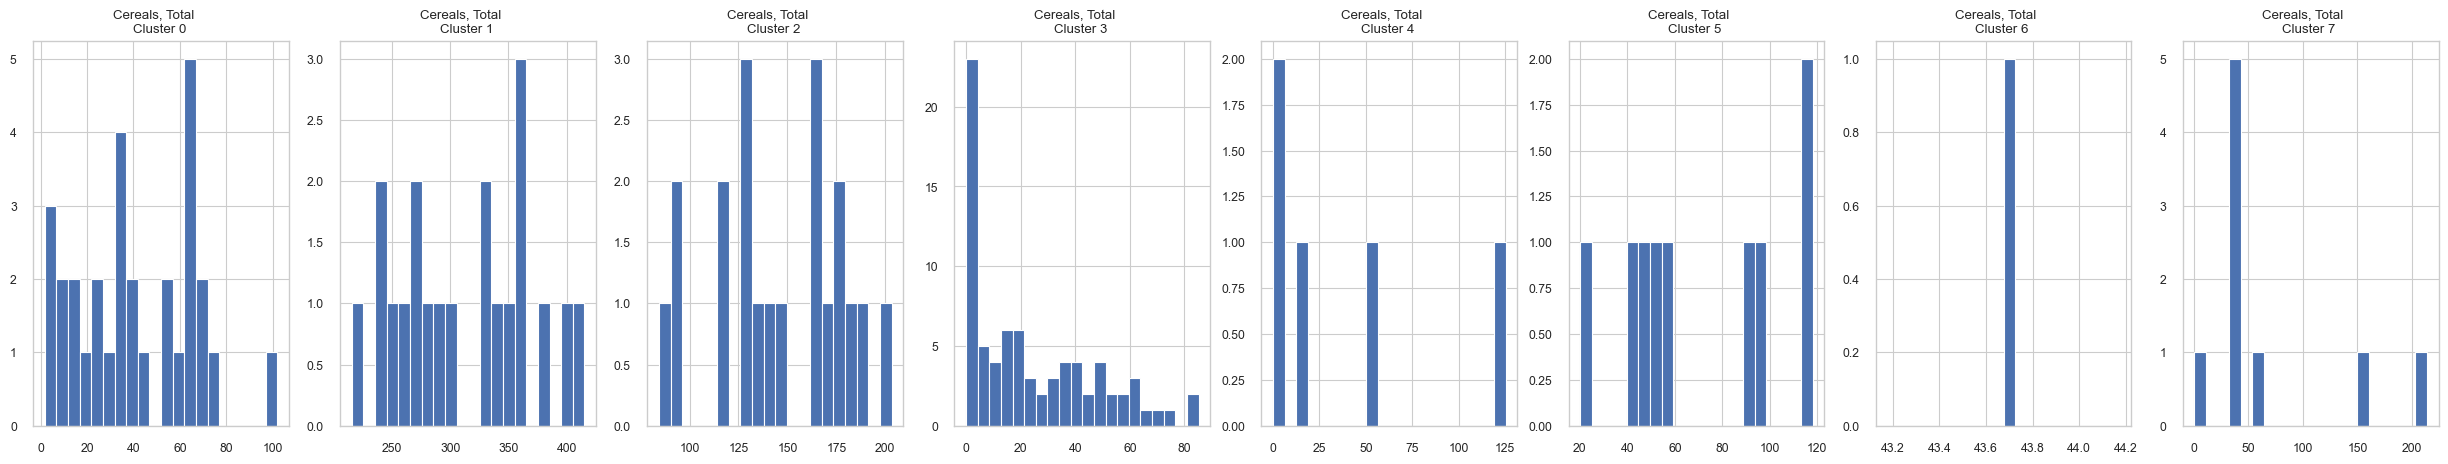

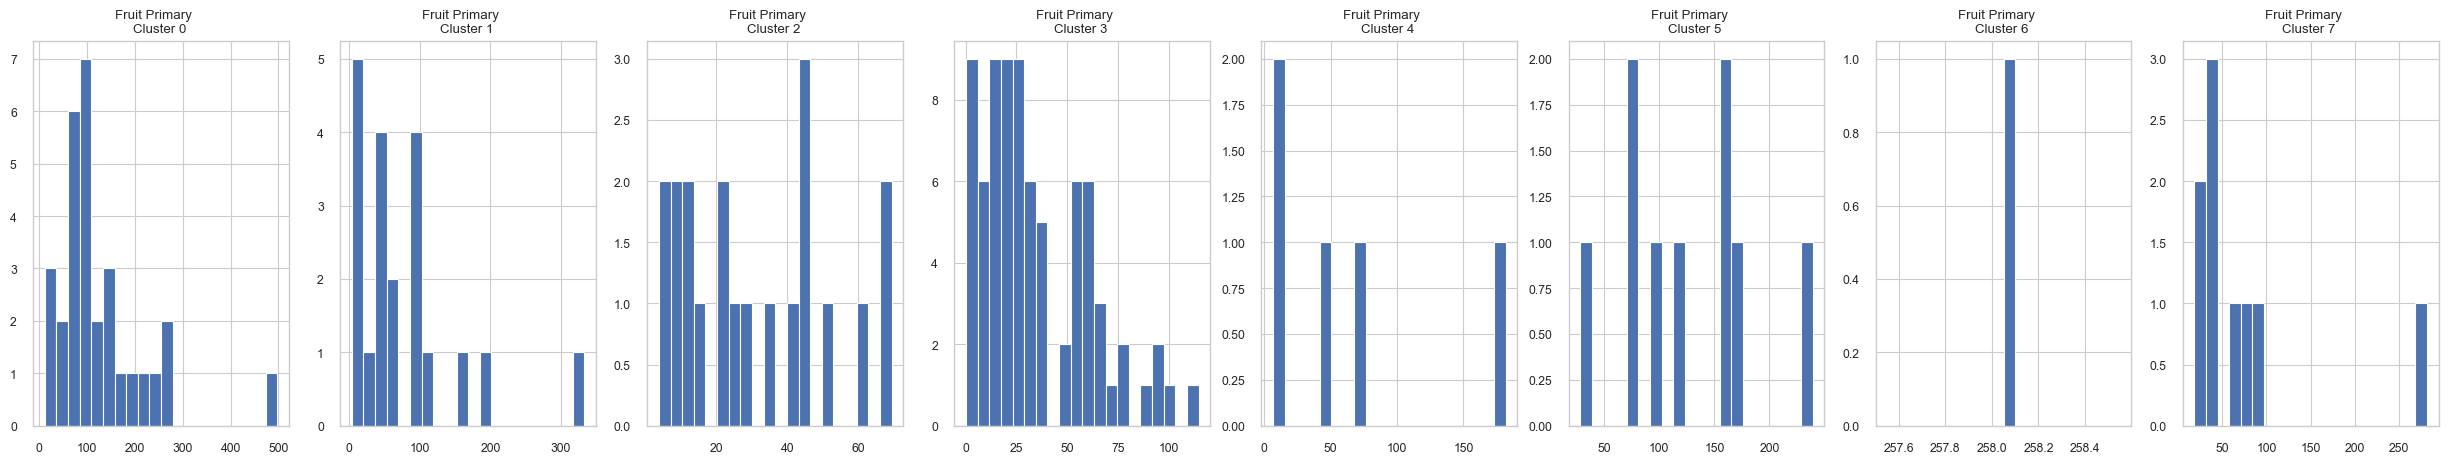

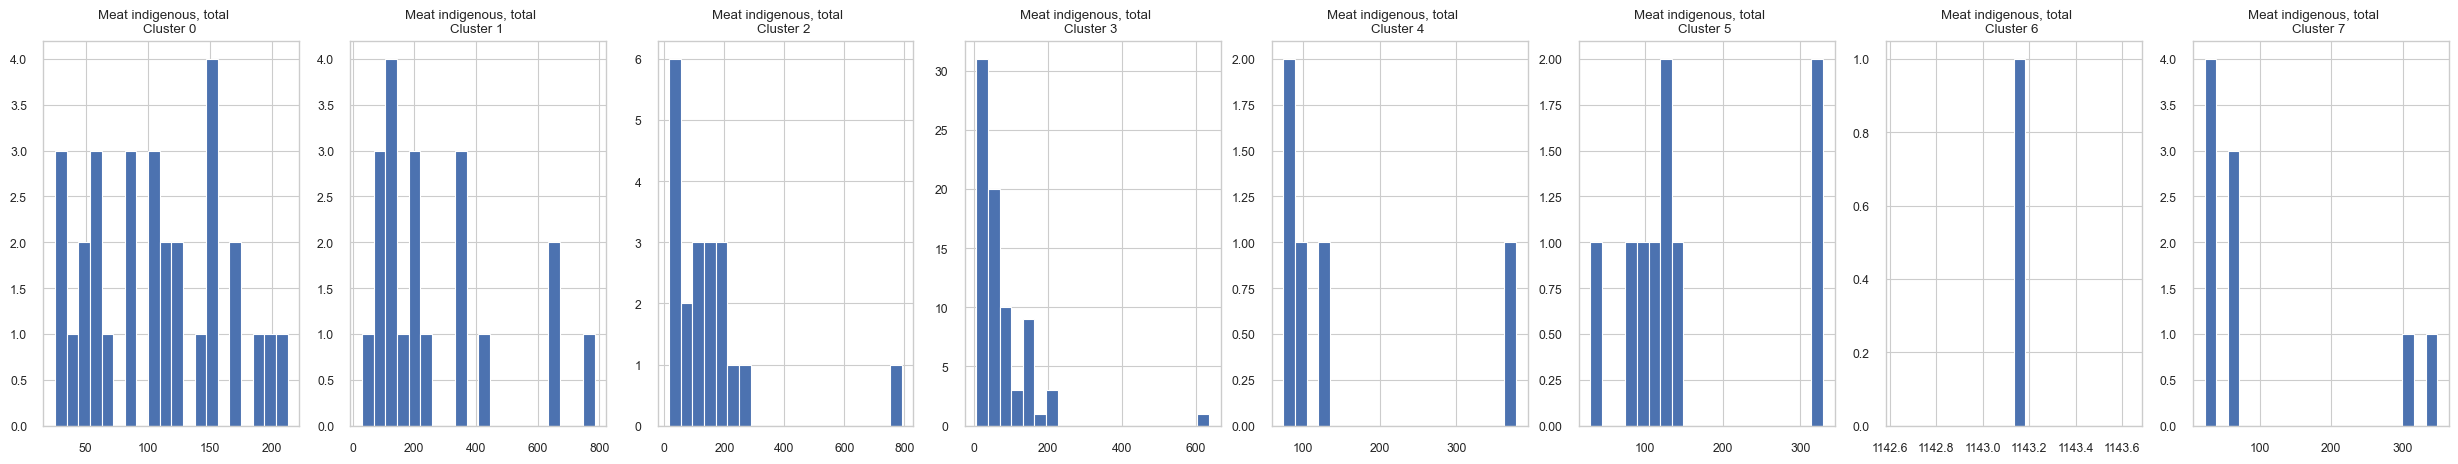

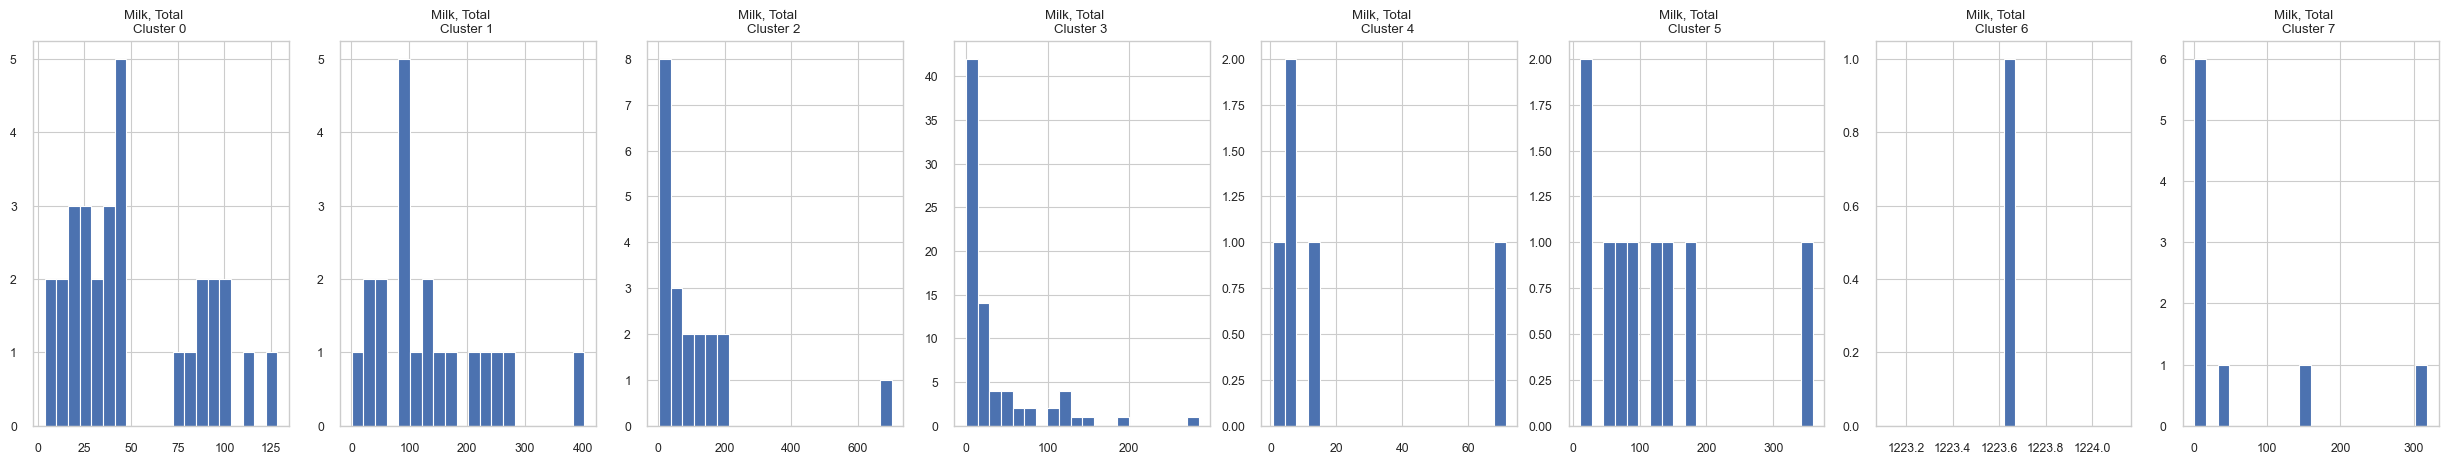

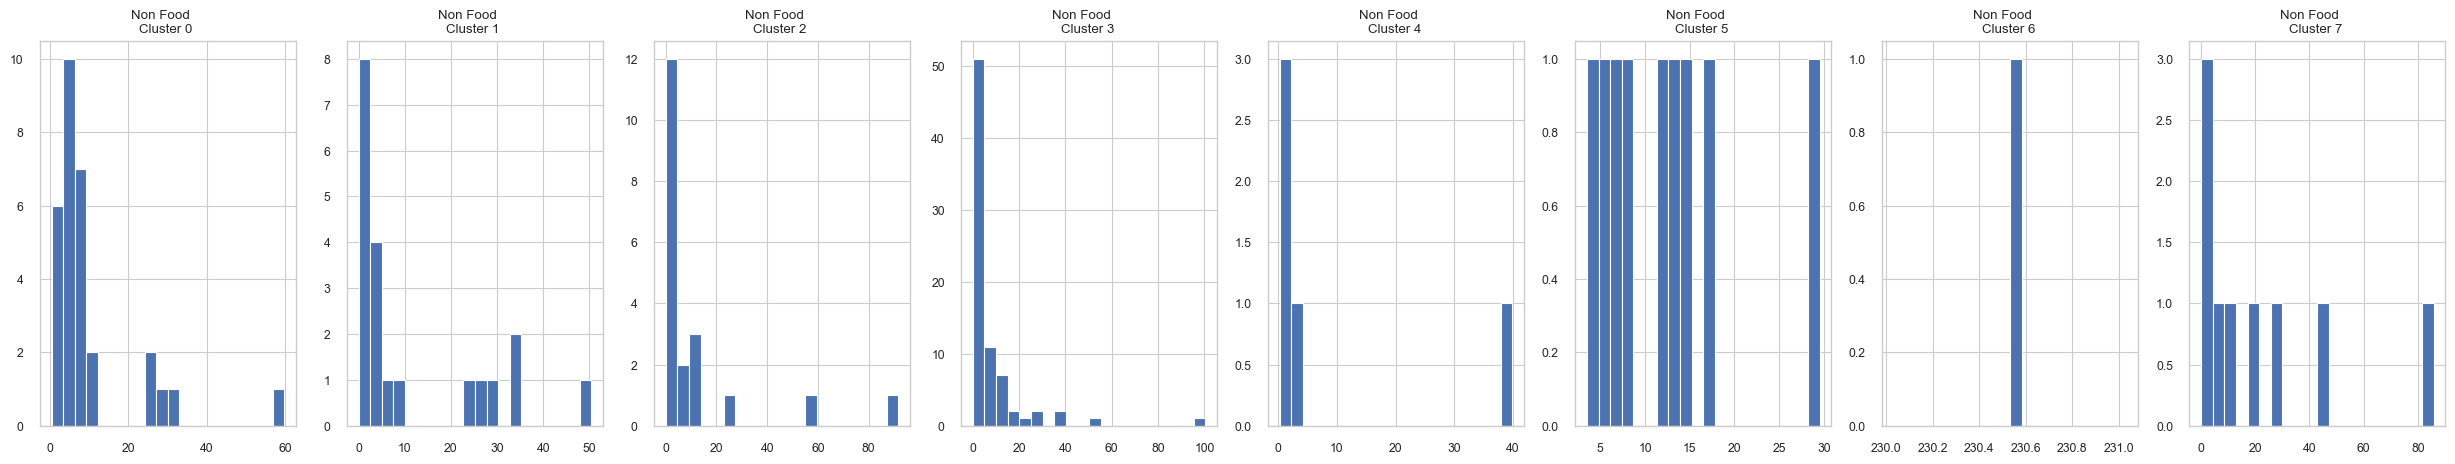

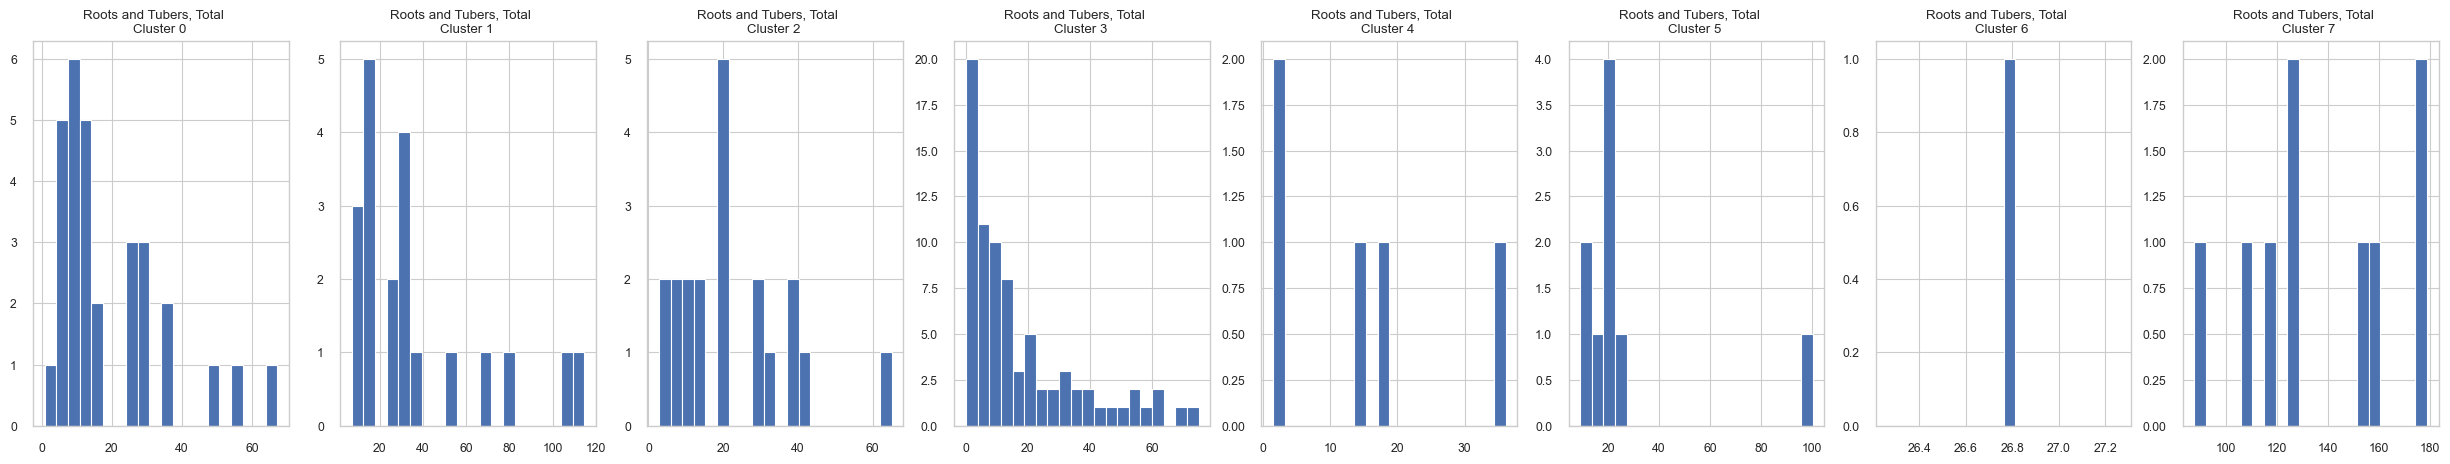

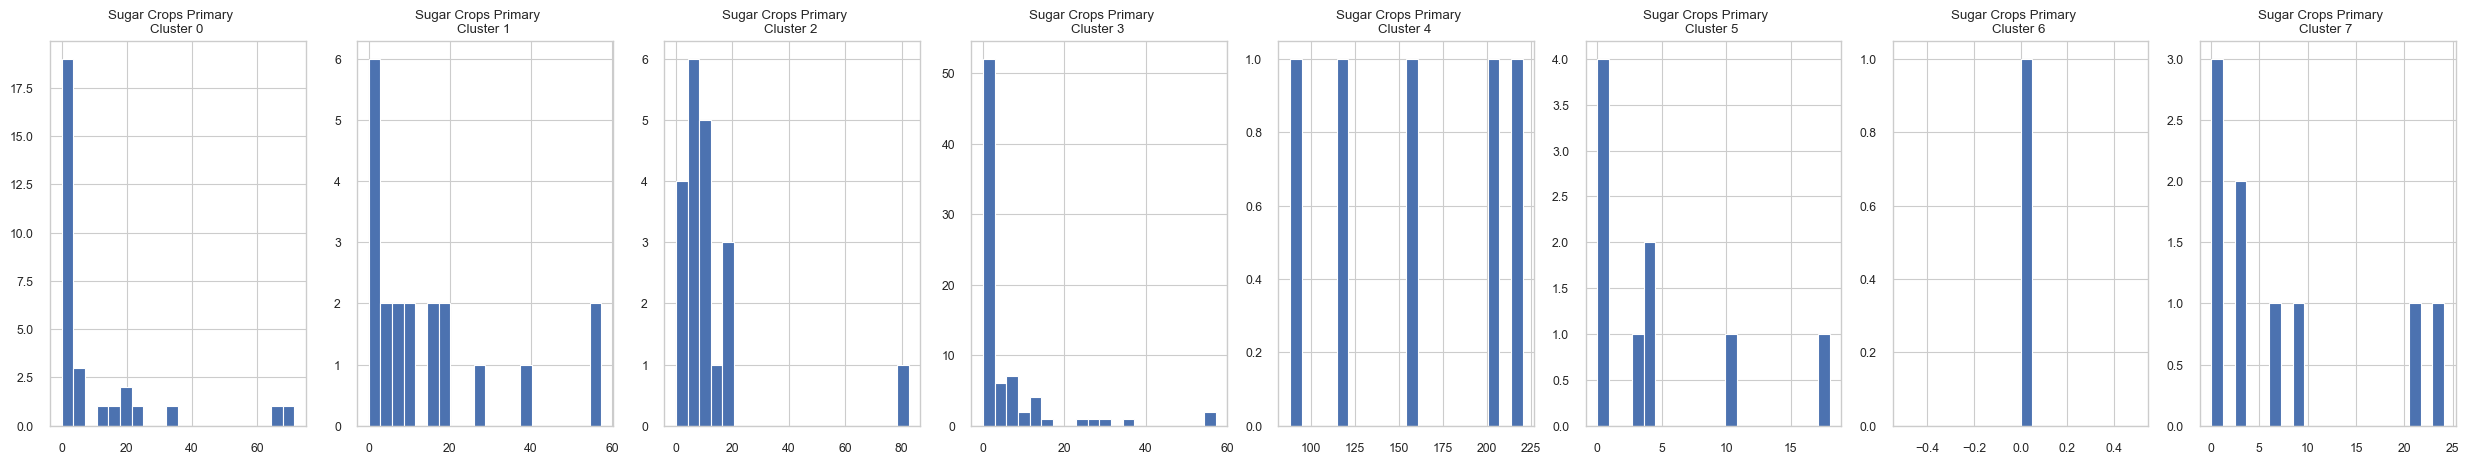

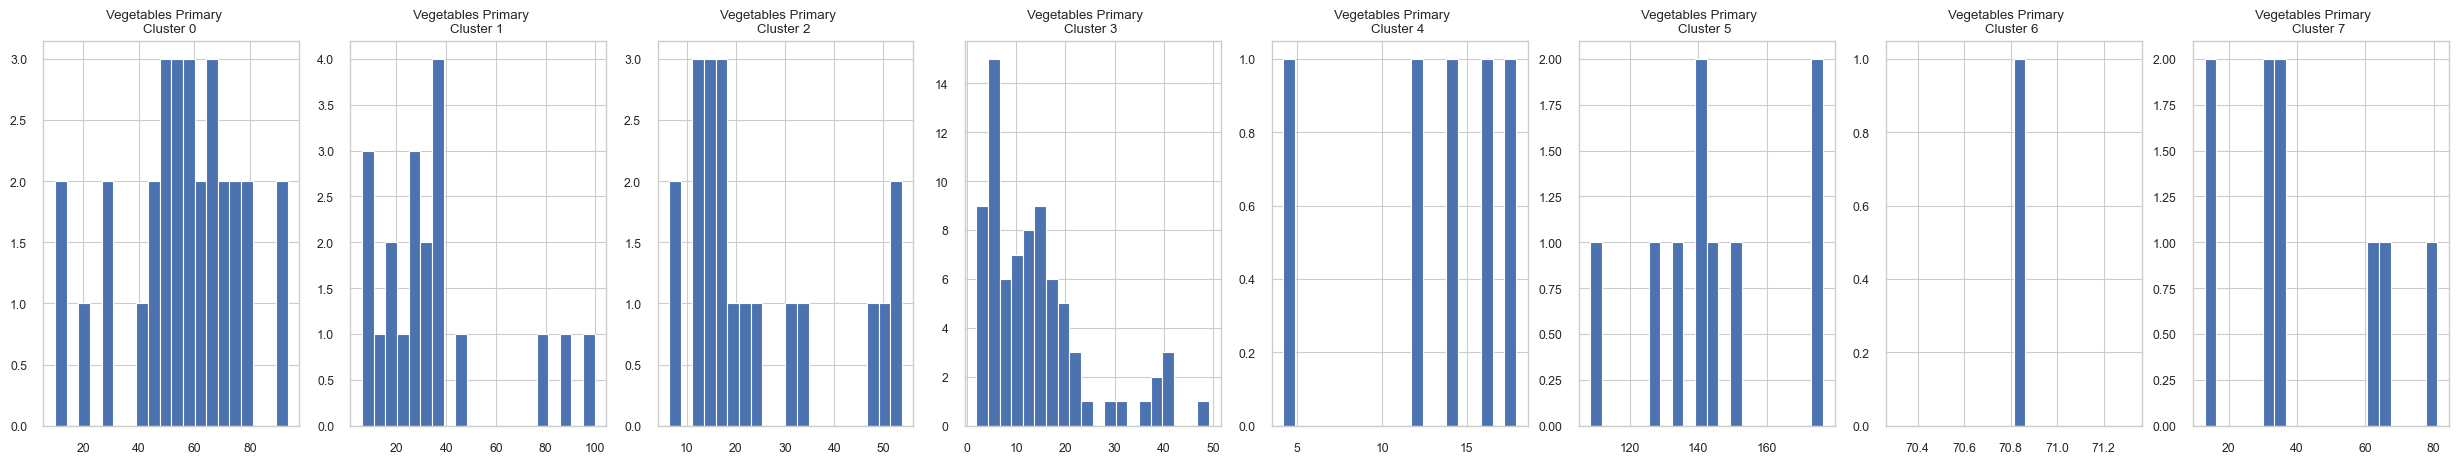

In [36]:
for i in prod19_df.columns:
    if i != 'cluster_no':
        plt.figure(figsize = (35, 5))
        for j in range(1,n_clusters+1):
            plt.subplot(1,n_clusters+1,j+1)
            cluster = prod19_df[prod19_df['cluster_no'] == j-1]
            cluster[i].hist(bins = 20)
            plt.title('{}    \nCluster {} '.format(i,j-1))
  
    plt.show()

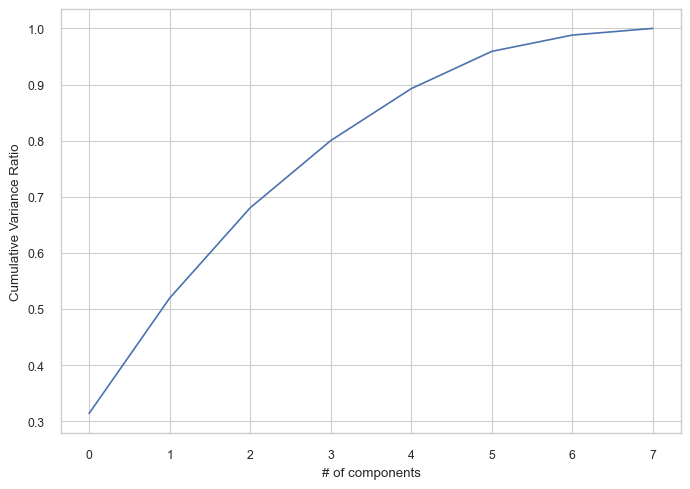

In [37]:
pca = PCA().fit(data19_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("# of components")
plt.ylabel("Cumulative Variance Ratio")
plt.show()

In [38]:
for i in range(prod19_df.shape[1]):
    pca = PCA(n_components=i)
    pca_fit = pca.fit_transform(data19_scaled)
    print(i, pca.explained_variance_ratio_.sum())

0 0.0
1 0.3141818512334256
2 0.5195256476372975
3 0.6804101254425531
4 0.8000971860709748
5 0.8926267488209028
6 0.9590414966308767
7 0.9880694517456606
8 1.0


In [39]:
#Only for easy visualization, we pick 2 variables.
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(data19_scaled)
pca.explained_variance_ratio_

array([0.31418185, 0.2053438 ])

In [40]:
# Convert to a data frame
X_reduceddf = pd.DataFrame(pca_fit, index=data19_scaled.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = clusters
X_reduceddf.head()

PC1       PC2  cluster
Area                                    
Afghanistan -0.192441 -0.085735        3
Albania      0.164829  0.658966        5
Algeria     -0.050845  0.254653        0
Angola      -0.180009 -0.057812        3
Argentina    0.733493 -0.289497        1

In [41]:
#https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/functions.py
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)
            
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=sns.color_palette("Paired"))

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

C:\Users\blancc2\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


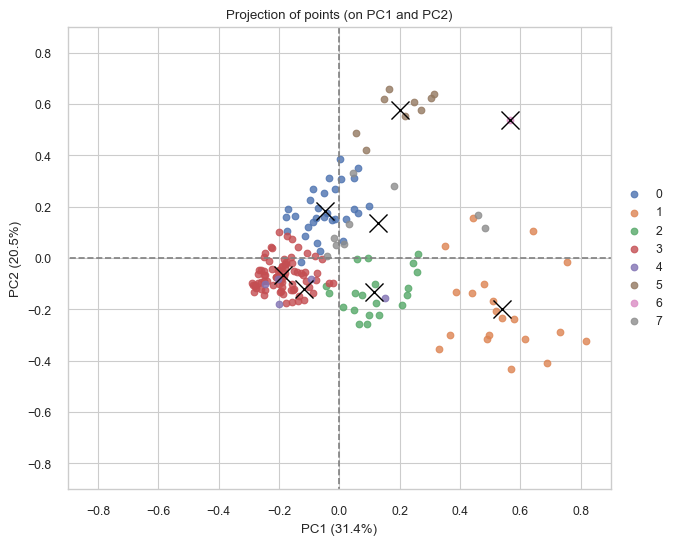

In [42]:
from sklearn.decomposition import PCA
centres_reduced = pca.transform(kmeans.cluster_centers_);
display_factorial_planes(pca_fit, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8);
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=1,
            color='black', zorder=10);

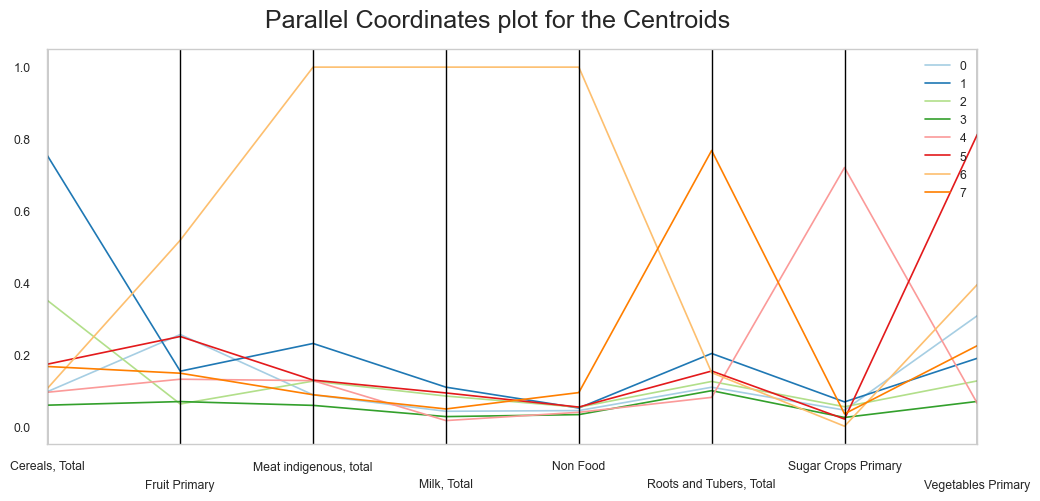

In [43]:
from pandas.plotting import parallel_coordinates
palette = sns.color_palette("bright", 10)


# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(data19_scaled, index=data19_scaled.index, columns=data19_scaled.columns)
X_clustered["cluster"] = clusters
means =  X_clustered.groupby(by="cluster").mean()
display_parallel_coordinates_centroids(means.reset_index(), 5)

In [44]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations");
print(get_top_abs_correlations(data19_scaled, 5));

Top Absolute Correlations
Item                     Item                  
Meat indigenous, total   Milk, Total               0.781458
Milk, Total              Non Food                  0.508540
Meat indigenous, total   Non Food                  0.467034
Roots and Tubers, Total  cluster                   0.436146
Cereals, Total           Meat indigenous, total    0.359835
dtype: float64


In [45]:
codes_df = pd.read_csv(pop_folder /"Population_E_AreaCodes.csv", encoding = 'unicode_escape');
prod19_df=prod19_df.merge(codes_df, on='Area', how='left');

cc = coco.CountryConverter();
prod19_df['iso']=cc.pandas_convert(prod19_df['Area'], to='ISO3');

In [46]:
import plotly.express as px

In [47]:
fig = px.choropleth(prod19_df, 
                    locations=prod19_df['iso'], 
                    color="cluster_no",
                     hover_name="cluster_no",
                    labels={'cluster_no':'Cluster'},
                    title='foo',
                    color_continuous_scale=px.colors.sequential.Plasma,
                   )
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(title_text='Map of countries clustered by production behavior',title_x = 0.4, title_y=0.9,margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [48]:
cluster_ire=prod19_df['cluster_no'][prod19_df['Area']=='Ireland'].values[0]
print("Regions in the same cluster than Ireland: \n")
#use to_string function to remove the "Name", "Dtype" from the output. 
print(prod19_df['Area'][prod19_df['cluster_no']==cluster_ire].to_string(index=False))

Regions in the same cluster than Ireland: 

                                           Austria
                                        Bangladesh
                                           Croatia
                                           Czechia
                                           Finland
                                           Germany
                                            Guinea
                                         Indonesia
                                           Ireland
                                              Mali
                                           Myanmar
                                             Nepal
                                            Poland
                                Russian Federation
                                          Slovakia
                                          Suriname
                                            Sweden
                                          Thailand
United Kingdom of Great Britain and No

In [49]:
prod19_df[prod19_df['cluster_no']==cluster_ire].head()

Area  Cereals, Total  Fruit Primary  Meat indigenous, total  \
7      Austria      129.367090      51.851814              244.388476   
10  Bangladesh      134.773630      14.964878               16.057212   
37     Croatia      176.956147      43.789797              124.603124   
40     Czechia      161.736440      12.421429              104.916441   
55     Finland      146.348924       7.382727              179.401859   

    Milk, Total  Non Food  Roots and Tubers, Total  Sugar Crops Primary  \
7    179.420920  1.280076                21.173229            10.425859   
10     9.966002  7.549592                14.893519             0.906715   
37    62.397209  4.544099                10.493124             8.083294   
40   125.320221  0.075354                14.787882            16.370515   
55   178.952708  0.155210                28.052334             4.278157   

    Vegetables Primary  cluster_no  Area Code M49 Code  iso  
7            23.984622           2       11.0     '040  AUT  
10           14.477892           2       16.0     '050  BGD  
37           12.333186           2       98.0     '191  HRV  
40            6.474598           2      167.0     '203  CZE  
55           17.558155           2       67.0     '246  FIN

In [50]:
#prod_wide=pd.wide_to_long(prod_df, stubnames='Y', i=['Area', 'Item'], j='Year').reset_index()

In [51]:
prod_clust=prod_df

In [52]:
countries_ire = prod19_df["Area"][prod19_df['cluster_no']==cluster_ire].unique()

In [53]:
def select_countries_cluster(country, country_list, max_num):
    if (len(country_list)<= max_num):
        return country_list
    else:
        country_list.remove(country)
        sample_list=[country]
        sample_list+=random.sample(country_list, max_num-1)
        return sorted(sample_list)

In [54]:
sample_countries=select_countries_cluster('Ireland', list(countries_ire), 10)

In [55]:
prod_clust = prod_clust[prod_clust["Area"].isin(sample_countries)]
prod_clust = prod_clust[prod_clust["Item"].isin(['Cereals, Total','Fruit Primary',
                                    'Meat indigenous, total','Milk, Total',
                                    'Non Food','Roots and Tubers, Total',
                                    'Sugar Crops Primary','Vegetables Primary'])]
prod_clust = prod_clust[(prod_clust["Year"]>=1999) & (prod_clust["Year"]<=2019)]

In [56]:
prod_clust= prod_clust.merge(pop_df[["Area", "Year", "Total_Population"]], how='left', on=['Area', 'Year'])
prod_clust["Prod_pop"]=prod_clust["Total_Prod"]/prod_clust["Total_Population"]

In [57]:
#create_report(prod_wide).show_browser()

In [58]:
#STREAMLIT APP

for item in prod_wide['Item'].unique():
    fig = plt.figure(figsize=(8,7))
    plt.title(item)
    sns.lineplot(data=prod_wide[prod_wide['Item']==item].drop('Item', axis=1), x='Year', y='Y', hue='Area')
    st.pyplot(fig)

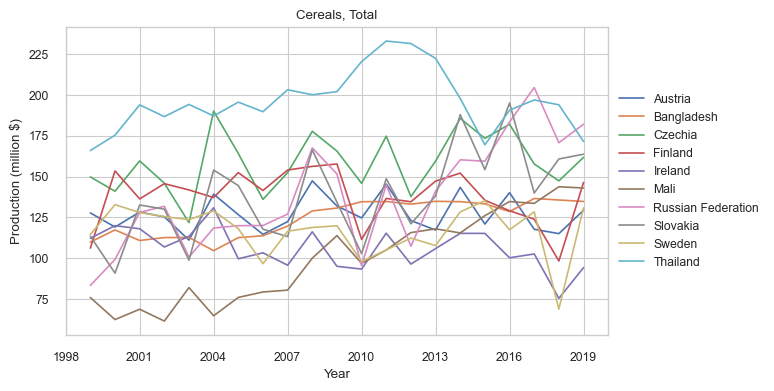

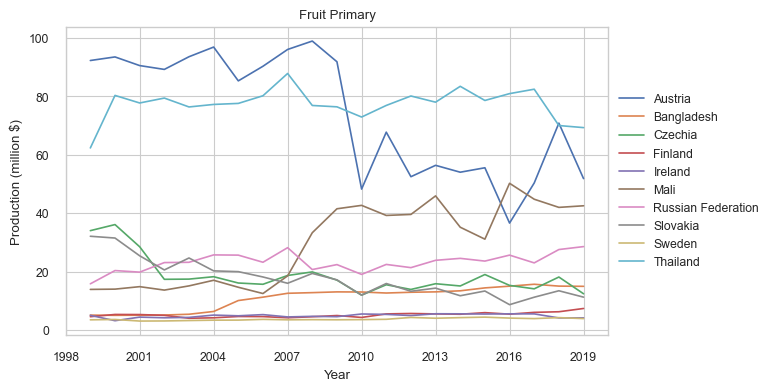

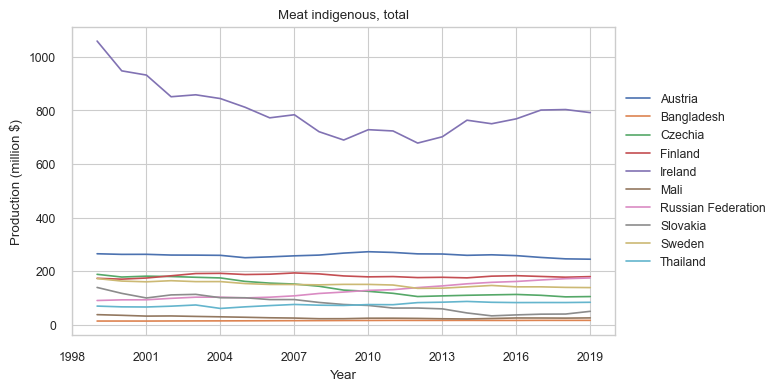

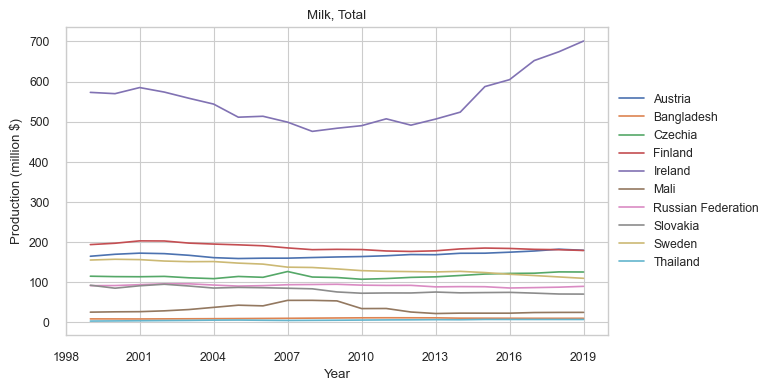

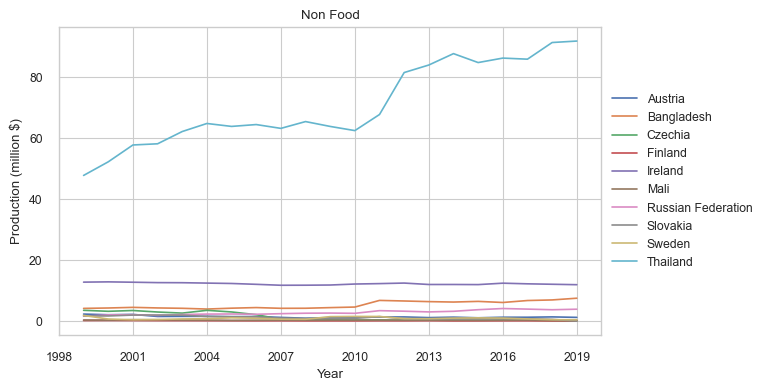

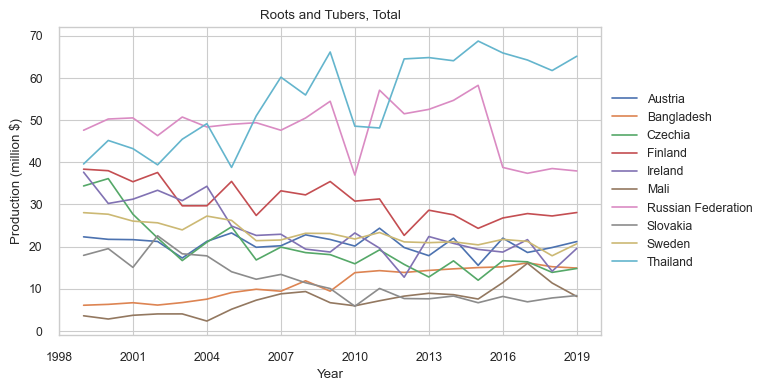

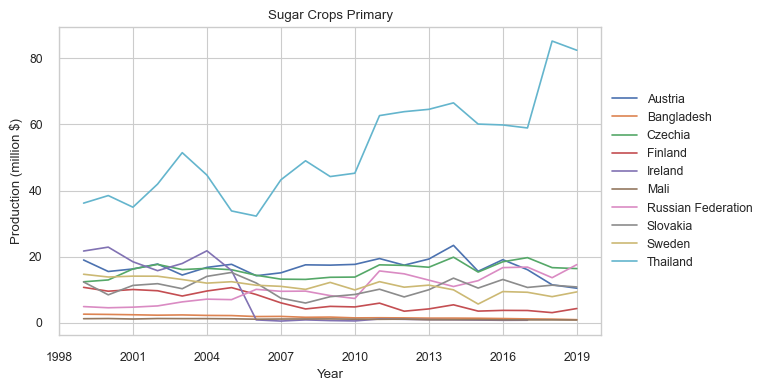

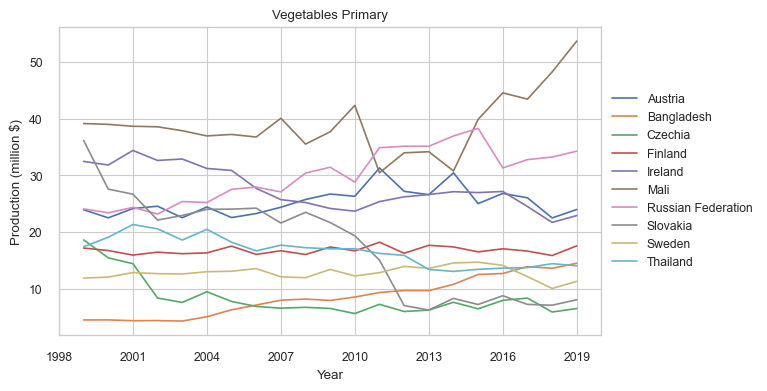

In [59]:
for item in prod_clust['Item'].unique():
    fig = plt.figure(figsize=(7,4))
    ax = plt.subplot(111)
    plt.title(item)
    sns.lineplot(data=prod_clust[prod_clust['Item']==item].drop('Item', axis=1), x='Year', y='Prod_pop', hue='Area')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Production (million $)')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show(fig)

In [60]:
prod_clust.head()

Area            Item  Year  Total_Prod  Total_Population    Prod_pop
0  Austria  Cereals, Total  1999   1020955.0          7991.377  127.757081
1  Austria  Cereals, Total  2000    954187.0          8010.428  119.118105
2  Austria  Cereals, Total  2001   1031311.0          8039.626  128.278480
3  Austria  Cereals, Total  2002   1012558.0          8078.992  125.332220
4  Austria  Cereals, Total  2003    902344.0          8120.104  111.124685

C:\Users\blancc2\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



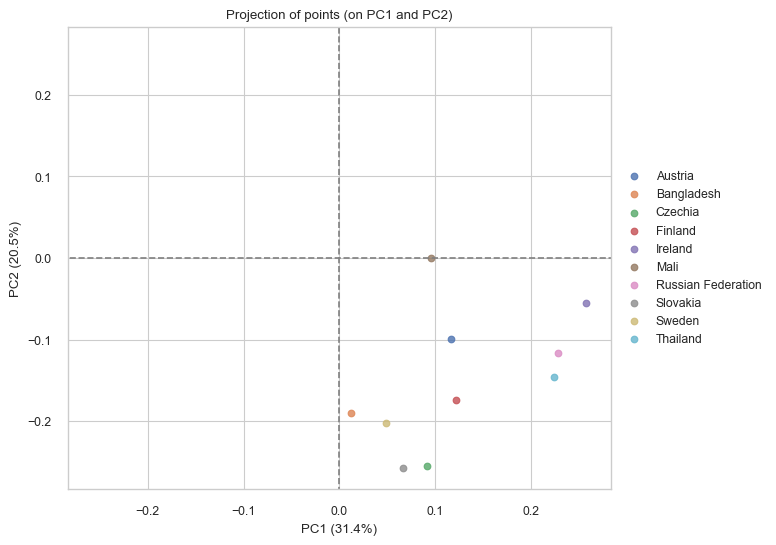

In [61]:
from sklearn.decomposition import PCA
centres_reduced = pca.transform(kmeans.cluster_centers_);
display_factorial_planes(pca_fit[prod19_df['Area'].isin(list(prod_clust['Area']))], 2, pca, [(0,1)], illustrative_var = prod19_df['Area'][prod19_df['Area'].isin(list(prod_clust['Area']))], alpha = 0.8);

In [62]:
#Declare variables

#Countries chosen to be analyzed
country1='Ireland'
country2='Austria'

#Product used for individual analysis - Country 1
prod_ind='Apples'
#Product used to compare Country 1 vs Country 2
prod_comp='Barley'

In [63]:
country1_df=prod_df[prod_df['Area']==country1].pivot(index='Year', columns='Item', values='Total_Prod')
country2_df=prod_df[prod_df['Area']==country2].pivot(index='Year', columns='Item', values='Total_Prod')

In [88]:
def confidence_interval(array, alpha):
    result=stats.t.interval(confidence=alpha, df=len(array)-1,
              loc=np.mean(array),
              scale=stats.sem(array))
    print("("+ str(round(result[0],3)) +" , "+ str(round(result[1],3))+")")

print("Confidence interval of yearly production of "+prod_ind+ " in "+country1+":")

for i in [0.9, 0.95, 0.99]:
    print("\nAt "+str(int(i*100))+"%:")
    confidence_interval(country1_df[prod_ind], i)

Confidence interval of yearly production of Apples in Ireland:

At 90%:
(6339.171 , 7571.662)

At 95%:
(6217.514 , 7693.32)

At 99%:
(5973.845 , 7936.988)


In [65]:
def test_normality(df, country_name, pvalue=0.05, model='shapiro'):
    print("\n---Normal variables following", model, "Test in", country_name,"---\n")
    for col in df.columns:
        result=getattr(stats,model)(df[col])
        if result[1] > pvalue and not math.isnan(result[0]):
            print(col,":")
            print("\t\tStat:", round(result[0],4),"\t\tP-Value:", round(result[1],4))


In [66]:
test_normality(country1_df, country1)


---Normal variables following shapiro Test in Ireland ---

Barley :
		Stat: 0.9716 		P-Value: 0.1744
Crops :
		Stat: 0.9653 		P-Value: 0.0854
Fruit Primary :
		Stat: 0.9631 		P-Value: 0.0667
Non Food :
		Stat: 0.9747 		P-Value: 0.2472
Peas, dry :
		Stat: 0.9697 		P-Value: 0.1403
Shorn wool, greasy, including fleece-washed shorn wool :
		Stat: 0.9726 		P-Value: 0.1955


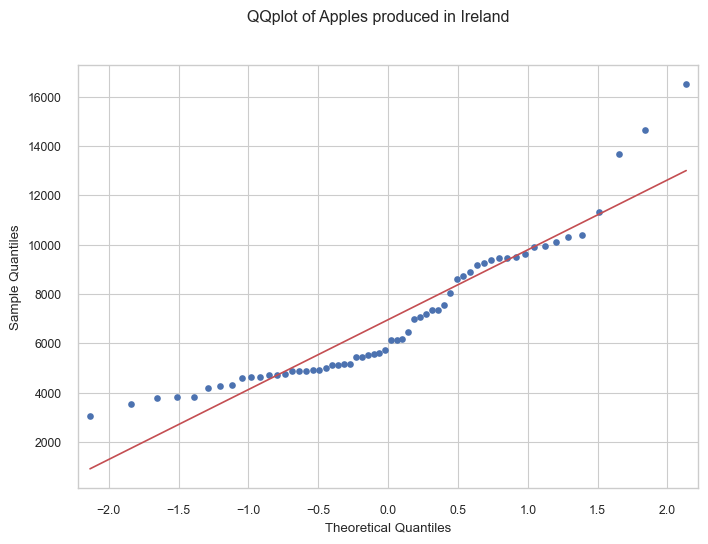

In [67]:
g = sm.qqplot(country1_df[prod_ind], line='s')

g.suptitle("QQplot of "+ prod_ind + " produced in " + country1)
# displaying heatmap
plt.show()

In [68]:
### T-Test Ireland

t_test_eq = stats.ttest_1samp(country1_df[prod_comp],0.95*country1_df[prod_comp].mean())
print(t_test_eq)
#P-value > 0.05 Fail to reject H0 -> Accept that average production is 0.95*...
t_test_less = stats.t.sf(t_test_eq[0], len(country1_df[prod_comp])-1)
print(t_test_less)
#P-value > 0.05 Fail to reject H0 -> Accept that average production is 0.95*...

Ttest_1sampResult(statistic=1.3812683019359595, pvalue=0.17240559754214663)
0.08620279877107331


In [69]:
#Chi-squared tests provide a way to investigate differences in the distributions of categorical variables with the same categories
#and the dependence between categorical variables. 

#from scipy.stats import chisquare
#chisquare(country1_df['Wheat'])

In [70]:
test_normality(country2_df,country2, 0.05, 'shapiro')


---Normal variables following shapiro Test in Austria ---

Apples :
		Stat: 0.9852 		P-Value: 0.678
Barley :
		Stat: 0.9625 		P-Value: 0.0622
Crops :
		Stat: 0.9631 		P-Value: 0.067
Fruit Primary :
		Stat: 0.9706 		P-Value: 0.1569
Natural honey :
		Stat: 0.9686 		P-Value: 0.1245
Peaches and nectarines :
		Stat: 0.9665 		P-Value: 0.0984
Pears :
		Stat: 0.9649 		P-Value: 0.0816
Peas, green :
		Stat: 0.9799 		P-Value: 0.4256
Sugar Crops Primary :
		Stat: 0.9846 		P-Value: 0.651
Sugar beet :
		Stat: 0.9846 		P-Value: 0.651
Vegetables Primary :
		Stat: 0.9726 		P-Value: 0.1962
Vegetables and Fruit Primary :
		Stat: 0.964 		P-Value: 0.0739
Wheat :
		Stat: 0.9765 		P-Value: 0.2979


In [71]:
#Selecting Barley as article in both countries as it is normal.
prod='Barley'
prod_country1=country1_df[prod_comp]
prod_country2=country2_df[prod_comp]

--- Describe production of Barley in Ireland---
count        60.000000
mean     232059.466667
std       65067.912474
min      100413.000000
25%      190252.750000
50%      238282.000000
75%      282985.000000
max      344842.000000
Name: Barley, dtype: float64 

--- Describe production of Barley in Austria---
count        60.000000
mean     199096.766667
std       54488.174641
min       99667.000000
25%      162361.000000
50%      193203.000000
75%      238531.250000
max      296410.000000
Name: Barley, dtype: float64 



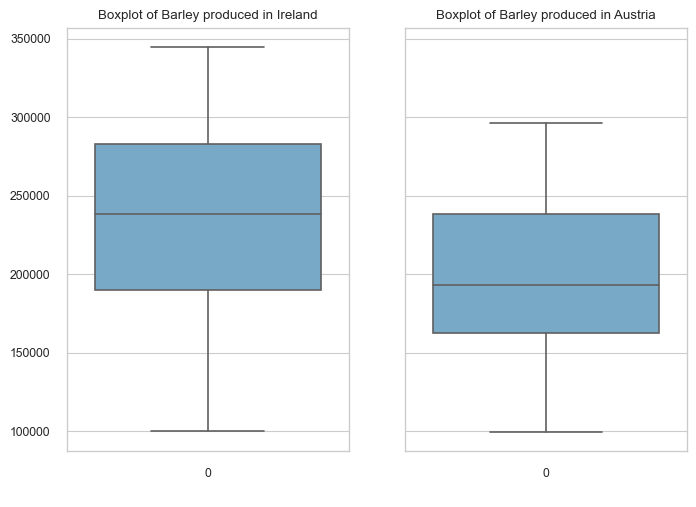

In [72]:
print("--- Describe production of", prod, "in Ireland---")
print(prod_country1.describe(),"\n")
print("--- Describe production of", prod, "in Austria---")
print(prod_country2.describe(),"\n")

fig, ax =plt.subplots(1,2, sharey=True);

sns.boxplot(data=prod_country1.reset_index()[prod_comp], palette="Blues", ax=ax[0]);
sns.boxplot(data=prod_country2.reset_index()[prod_comp], palette="Blues", ax=ax[1]);

ax[0].set_title('Boxplot of ' + prod + ' produced in Ireland');
ax[1].set_title(str('Boxplot of '+ prod +' produced in Austria'));

for i in ax.flat:
    i.set(xlabel=' ');
    
plt.show();

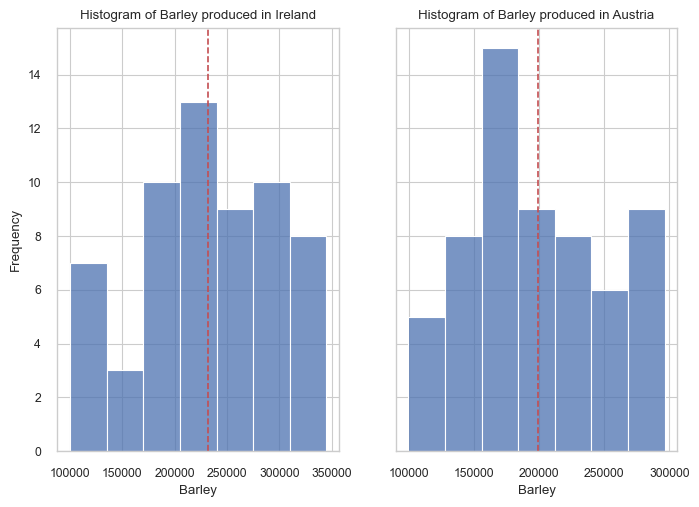

In [73]:
fig, ax =plt.subplots(1,2, sharey=True)

# Plot histograms
sns.histplot(prod_country1, ax=ax[0]);
sns.histplot(prod_country2, ax=ax[1]);

# Set plot titles
ax[0].set_title('Histogram of ' + prod + ' produced in Ireland')
ax[1].set_title(str('Histogram of '+ prod +' produced in Austria'))

# Set y-axis labels
for i in ax.flat:
    i.set(ylabel='Frequency')

# Add vertical lines for the mean
ax[0].axvline(prod_country1.mean(), color='r', linestyle='--')
ax[1].axvline(prod_country2.mean(), color='r', linestyle='--')

plt.show()

In [74]:
#Checking variances with Levene Homogeinity of variance: Levene's test

stats.levene(prod_country1, prod_country2, center = 'mean')

LeveneResult(statistic=1.27154338197908, pvalue=0.2617650005503895)

In [75]:
#H0 = variance are homogeneous
#H1 = variance are not homogeneous
#pvalue > 0.05 -> we do not reject the null hypothesis. There is not sufficient proof to say that the variances are not homogeneos. 

In [76]:
country1_df2=country1_df
country1_df2['Country']=country1
country2_df2=country2_df
country2_df2['Country']=country2

a=country1_df2[[prod_comp, 'Country']].reset_index()
b=country2_df2[[prod_comp, 'Country']].reset_index()

#We perform ANOVA

model = ols('Barley~Country', data = pd.concat([a,b])).fit()
aov = sm.stats.anova_lm(model, type = 2)
print(aov)

             df        sum_sq       mean_sq         F   PR(>F)
Country     1.0  3.259619e+10  3.259619e+10  9.050984  0.00321
Residual  118.0  4.249649e+11  3.601397e+09       NaN      NaN


In [77]:
#If the PR(>F) value is less than 0.05, it can be concluded that there is a significant difference between the means of the groups, and that this difference is not due to chance. On the other hand, if the PR(>F) value is greater than 0.05, it cannot be concluded that there is a significant difference between the means of the groups.

In [78]:
### T-Test Ireland vs Austria

#We perform the test assuming as H0 that mu1 = mu2 (family rate = business rate)
#We assume similar variance because of Levene Test
test = stats.ttest_ind(country1_df[prod_comp], country2_df[prod_comp], 
                      equal_var=True)

display(test)

Ttest_indResult(statistic=3.0084852991085014, pvalue=0.0032101460155396586)

In [79]:
#p-value < 0.05 -> The production of barley from the 2 countries is different

The Wilcoxon signed-rank test is the non-parametric univariate test which is an alternative to the dependent t-test. This is the recommended test to use when the data violates the assumption of normality. 

The hypothesis being test is:

Null hypothesis (H0): The difference between the pairs follows a symmetric distribution around zero.
Alternative hypothesis (HA): The difference between the pairs does not follow a symmetric distribution around zero.


Requirements:
The dependent variable (DV) must be continuous which is measured on an ordinal or continuous scale
The paired observations are randomly and independently drawn
The paired observations come from the same population

In [80]:
#Same population -> Ireland. From some years to other years.

#test_normality(country1_df[country1_df.index<1991])
#test_normality(country1_df[country1_df.index>=1991])

#Apples not normal.
stats.wilcoxon(country1_df[prod_ind][country1_df.index<1991], country1_df[prod_ind][country1_df.index>=1991])
#p-value < 0.05 -> Fail to reject H0. -> no significant change 

WilcoxonResult(statistic=220.0, pvalue=0.8078304156661034)

--- Describe production of Apples in Ireland until 1991---
count       30.000000
mean      6958.933333
std       3445.059650
min       3068.000000
25%       4731.750000
50%       5135.500000
75%       9086.000000
max      16520.000000
Name: Apples, dtype: float64 

--- Describe production of Apples in Ireland from 1991---
count       30.000000
mean      6951.900000
std       2175.240064
min       3540.000000
25%       5215.750000
50%       7033.000000
75%       9111.000000
max      10290.000000
Name: Apples, dtype: float64 



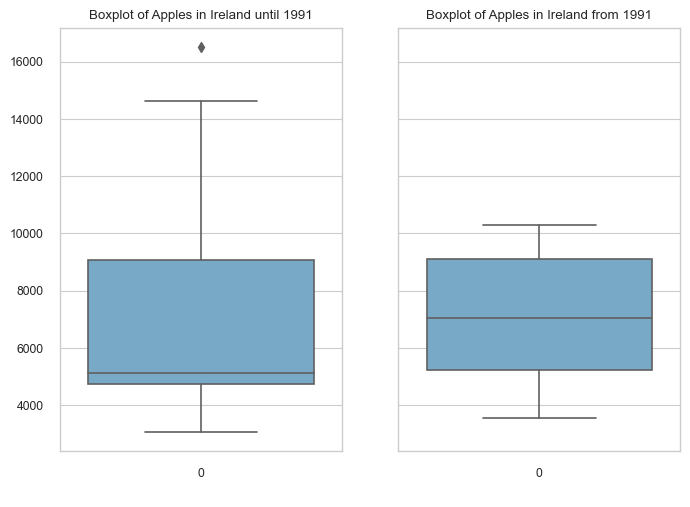

In [81]:
print("--- Describe production of", prod_ind, "in", country1, "until 1991---")
print(country1_df[prod_ind][country1_df.index<1991].describe(),"\n")
print("--- Describe production of", prod_ind, "in", country1, "from 1991---")
print(country1_df[prod_ind][country1_df.index>=1991].describe(),"\n")

fig, ax =plt.subplots(1,2, sharey=True);

sns.boxplot(data=country1_df[country1_df.index<1991].reset_index()[prod_ind], palette="Blues", ax=ax[0]);
sns.boxplot(data=country1_df[country1_df.index>=1991].reset_index()[prod_ind], palette="Blues", ax=ax[1]);

ax[0].set_title("Boxplot of "+ prod_ind+ " in "+ country1+ " until 1991");
ax[1].set_title("Boxplot of "+ prod_ind+ " in "+ country1+ " from 1991");

for i in ax.flat:
    i.set(xlabel=' ');
    
plt.show();

In [82]:
country1_df

Item  Agriculture   Apples    Barley  Beans, dry  \
Year                                               
1961    3621686.0  13688.0  100413.0         NaN   
1962    3524753.0  14632.0  117519.0         NaN   
1963    3527319.0  16520.0  114733.0         NaN   
1964    3534296.0  11328.0  107291.0         NaN   
1965    3486958.0   9912.0  119960.0         NaN   
1966    3623770.0   8024.0  124338.0         NaN   
1967    4102982.0   7552.0  131839.0         NaN   
1968    4077695.0   9440.0  146587.0         NaN   
1969    4012820.0  10384.0  153523.0         NaN   
1970    3992777.0   9440.0  152354.0         NaN   
1971    4429068.0   6136.0  193267.0         NaN   
1972    4215478.0   4295.0  191144.0         NaN   
1973    4089275.0   5617.0  176240.0         NaN   
1974    4580805.0   4720.0  202229.0         NaN   
1975    5222494.0   4862.0  198528.0         NaN   
1976    4690738.0   5098.0  179630.0         NaN   
1977    5284878.0   4626.0  281524.0         NaN   
1978    5534904.0   4767.0  271977.0         NaN   
1979    5309150.0   4720.0  303539.0         NaN   
1980    5791687.0   4201.0  331399.0         NaN   
1981    5074748.0   3068.0  325360.0         NaN   
1982    5440663.0   4248.0  326528.0         NaN   
1983    5687316.0   4885.0  292824.0         NaN   
1984    6123281.0   6463.0  344842.0         NaN   
1985    6187976.0   5173.0  291070.0         NaN   
1986    6365541.0   4626.0  278212.0         NaN   
1987    6205711.0   4909.0  311527.0         NaN   
1988    6021022.0   4909.0  287368.0      4421.0   
1989    5857881.0   5522.0  258145.0      5945.0   
1990    6493828.0   5003.0  238272.0      3735.0   
1991    6408595.0   4862.0  223660.0         NaN   
1992    6517000.0   3823.0  227557.0         NaN   
1993    6280341.0   3823.0  186643.0         NaN   
1994    5993897.0   5428.0  177292.0         NaN   
1995    6126225.0   5570.0  211191.0         NaN   
1996    6463831.0   5428.0  238662.0         NaN   
1997    6457087.0   4578.0  211776.0         NaN   
1998    6614660.0   3776.0  209048.0         NaN   
1999    6942865.0   6136.0  248988.0         NaN   
2000    6598415.0   5098.0  255203.0         NaN   
2001    6693373.0   7363.0  248832.0         NaN   
2002    6394931.0   5145.0  187579.0         NaN   
2003    6494162.0   3540.0  233343.0         NaN   
2004    6593984.0   8732.0  258456.0         NaN   
2005    6287621.0   6986.0  199580.0         NaN   
2006    6234772.0   8590.0  221498.0         NaN   
2007    6355022.0   7080.0  219082.0         NaN   
2008    6183484.0   7363.0  252124.0         NaN   
2009    6045451.0   6183.0  239110.0         NaN   
2010    6305261.0   9959.0  238292.0         NaN   
2011    6493780.0   9629.0  275094.0         NaN   
2012    6131080.0   5711.0  245617.0         NaN   
2013    6428016.0   7174.0  323957.0         NaN   
2014    6870627.0   9251.0  337283.0         NaN   
2015    7182545.0   8874.0  338841.0         NaN   
2016    7354872.0  10290.0  288323.0         NaN   
2017    7849397.0  10086.0  293371.0         NaN   
2018    7849679.0   9506.0  230199.0         NaN   
2019    8151478.0   9383.0  288265.0         NaN   
2020    8264096.0   9190.0  262520.0         NaN   

Item  Broad beans and horse beans, dry  Broad beans and horse beans, green  \
Year                                                                         
1961                               NaN                                 NaN   
1962                               NaN                                 NaN   
1963                               NaN                                 NaN   
1964                               NaN                                 NaN   
1965                               NaN                                 NaN   
1966                               NaN                                 NaN   
1967                               NaN                                 NaN   
1968                               NaN                                 Na

# Machine Learning Trial

In [83]:
all_var=['Cereals, Total','Fruit Primary',
                                    'Meat indigenous, total','Milk, Total',
                                    'Non Food','Roots and Tubers, Total',
                                    'Sugar Crops Primary','Vegetables Primary']
var_y=['Milk, Total']
X=country1_df[all_var].drop(var_y,axis=1)
y=country1_df[var_y]
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

C:\Users\blancc2\AppData\Local\Temp\ipykernel_13860\3100865062.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



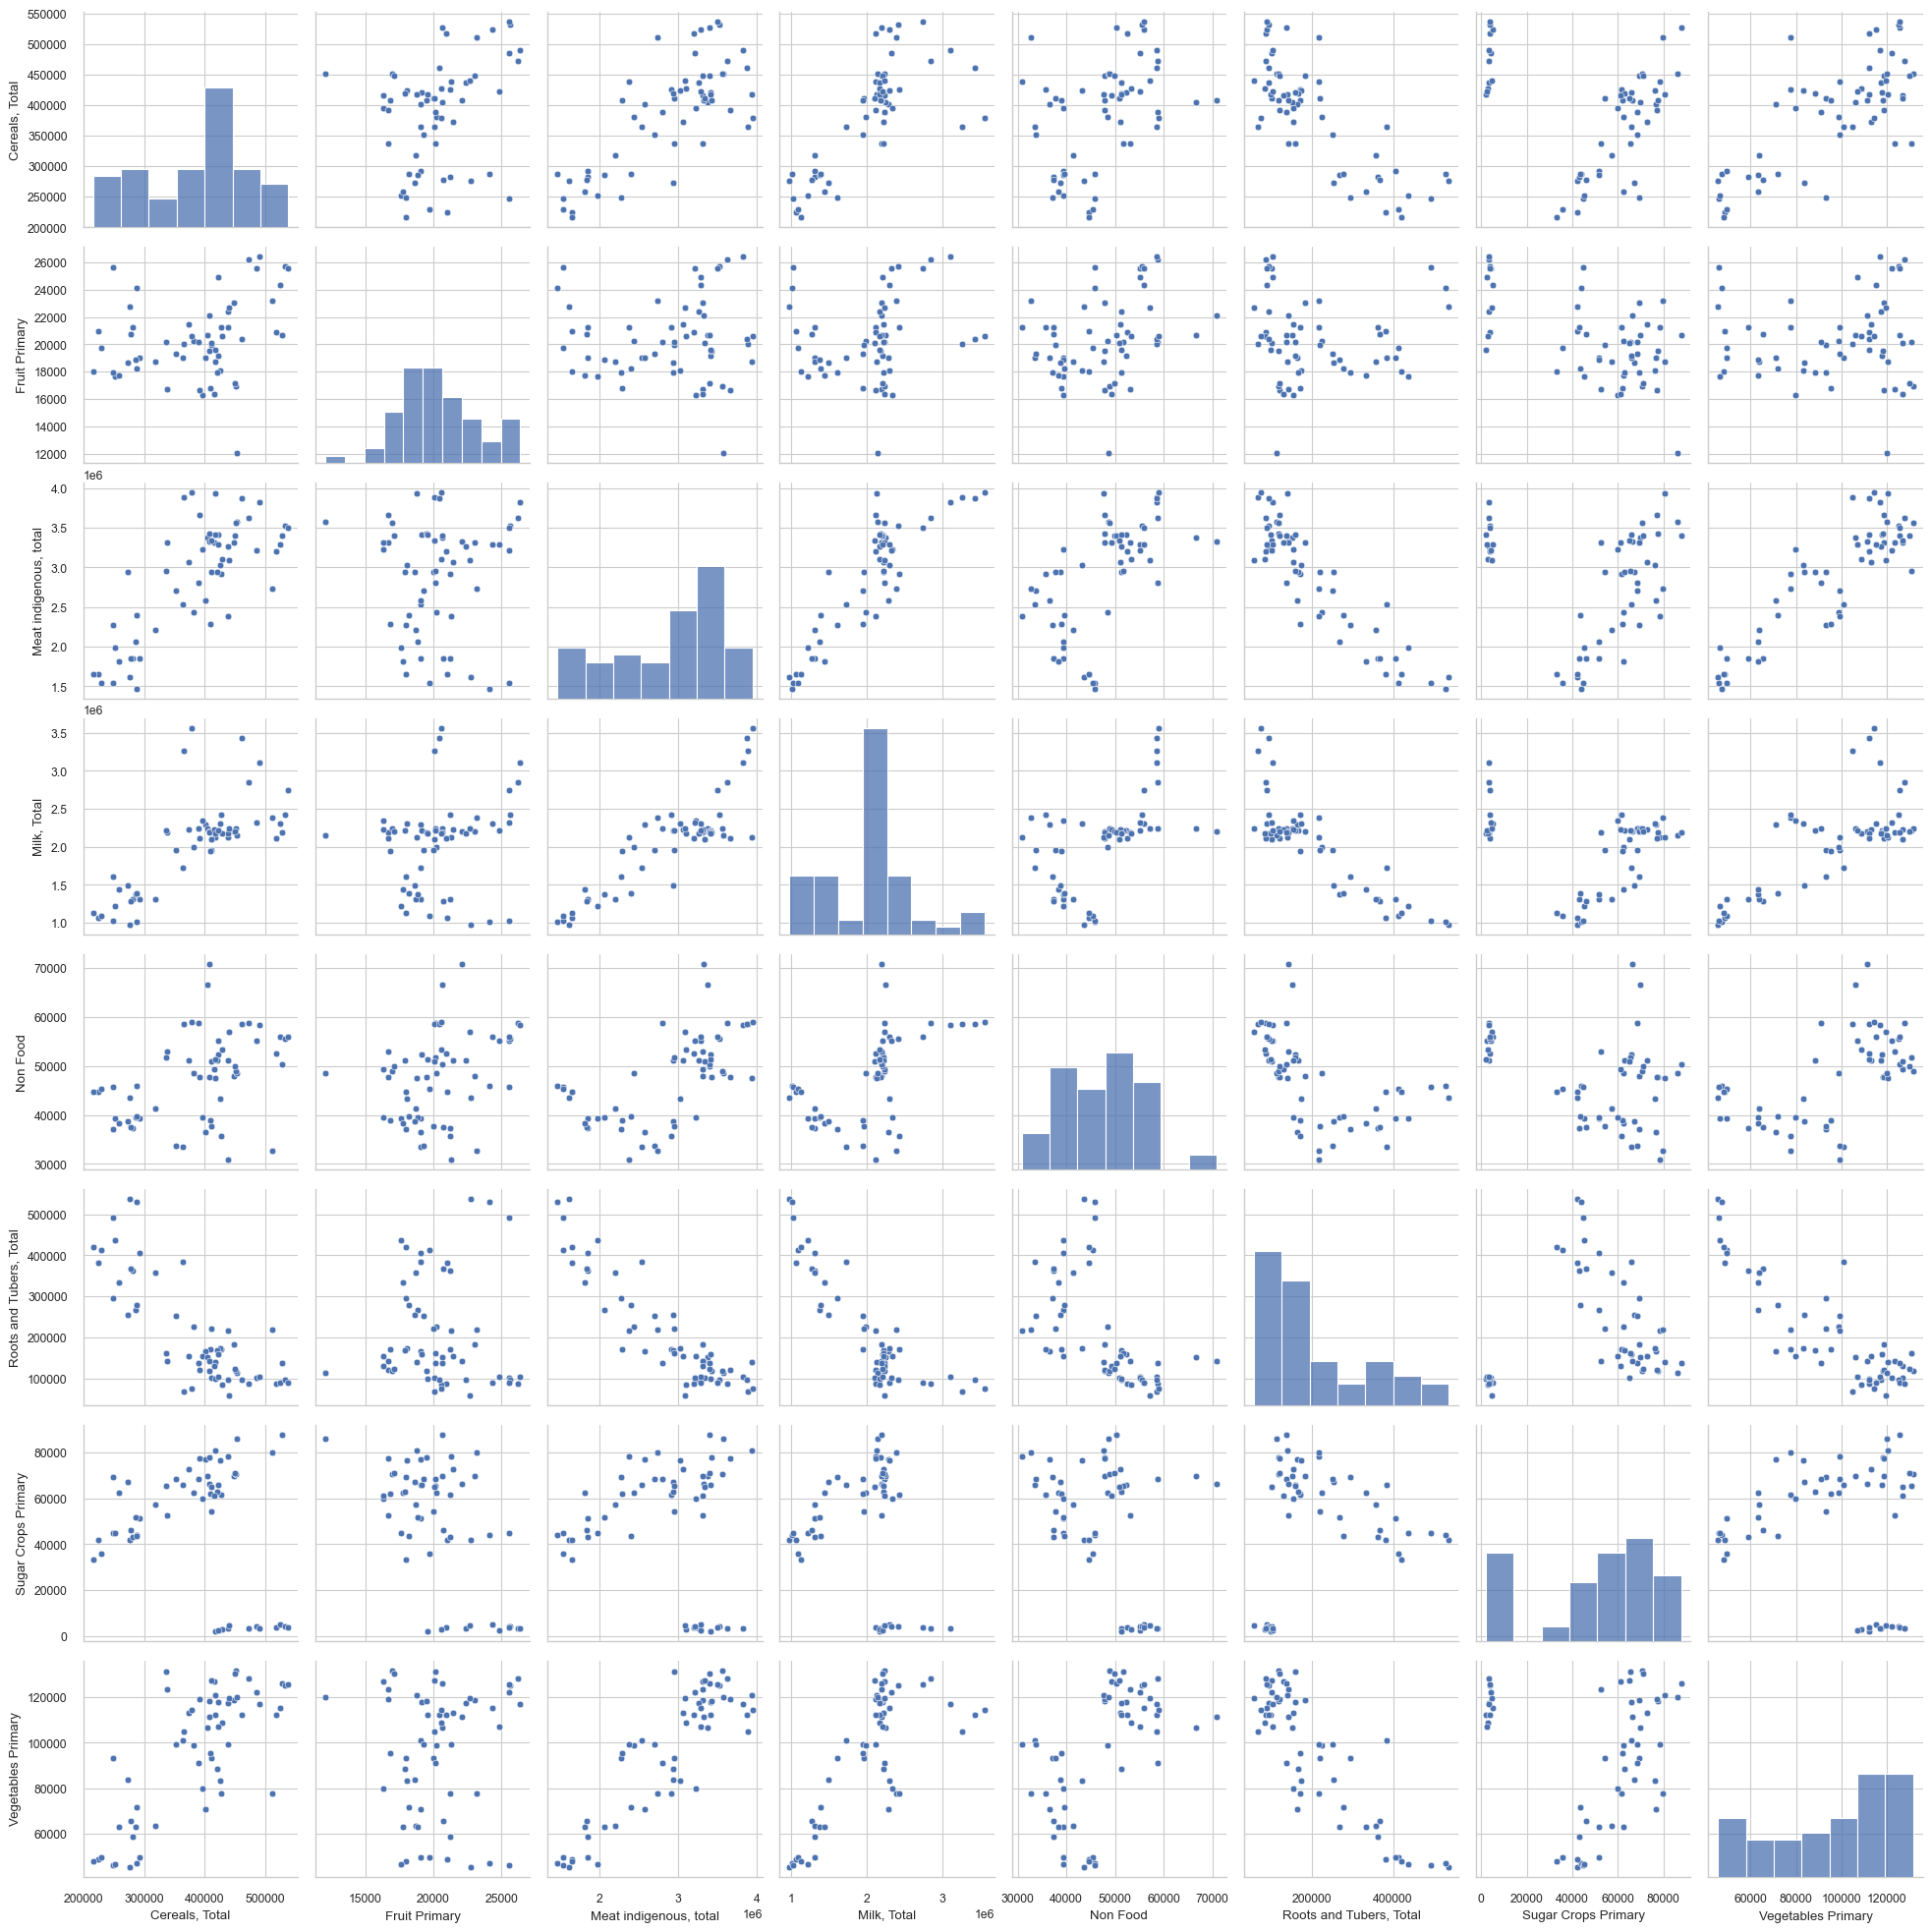

In [149]:
sns.pairplot(country1_df[all_var])

In [138]:
#Create empty DataFrame with specific column names & types
metrics_df = pd.DataFrame({'Model': pd.Series(dtype='str'),
                    'Rsquare_train': pd.Series(dtype='float'),
                    'Rsquare_test': pd.Series(dtype='float'),
                    'MAE': pd.Series(dtype='float'),
                    'MSE': pd.Series(dtype='float'),
                    'RMSE': pd.Series(dtype='float')})

In [140]:
def get_scores(model_name, model, score_df, X_train, Y_train, X_test, Y_test):
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)
    score_df = pd.concat([score_df,pd.DataFrame.from_records([{'Model':model_name, 
                                'Rsquare_train':model.score(X_train, Y_train),
                                'Rsquare_test':model.score(X_test, Y_test),
                                'MAE':metrics.mean_absolute_error(Y_test,y_preds_test),
                                'MSE':metrics.mean_squared_error(Y_test, y_preds_test),
                                'RMSE':np.sqrt(metrics.mean_squared_error(Y_test, y_preds_test))
                               }])])
    return score_df

## Linear Regression

In [141]:
lrm = LinearRegression()
lrm.fit(X_train, Y_train) #fit an OLS model

metrics_df=get_scores("Linear Regression", lrm, metrics_df, X_train, Y_train, X_test, Y_test)
metrics_df

Model  Rsquare_train  Rsquare_test            MAE  \
0  Linear Regression         0.8545      0.702974  208116.403244   

            MSE           RMSE  
0  8.093540e+10  284491.469623

## Ridge Regression

In [142]:
# Using GridSearch for parameter optimization
ridgeregr = GridSearchCV(Ridge(),
                    param_grid={
                        'alpha': [10**j for j in range(-1,12)]
                    }, verbose=1)

ridgeregr.fit(X_train, Y_train)
ridge = ridgeregr.best_estimator_

metrics_df=get_scores("Ridge Regression", ridge, metrics_df, X_train, Y_train, X_test, Y_test)
metrics_df

Fitting 5 folds for each of 13 candidates, totalling 65 fits


Model  Rsquare_train  Rsquare_test            MAE  \
0  Linear Regression       0.854500      0.702974  208116.403244   
0   Ridge Regression       0.834618      0.723926  213099.479034   

            MSE           RMSE  
0  8.093540e+10  284491.469623  
0  7.522608e+10  274273.729626

## Lasso Regression

In [143]:
# using GridSearch for parameter optimization
lassoregr = GridSearchCV(Lasso(),
                    param_grid={
                        'alpha': [10**j for j in range(-1,12)]
                    }, verbose=1)

lassoregr.fit(X_train, Y_train)

lasso = lassoregr.best_estimator_

metrics_df=get_scores("Lasso Regression", lasso, metrics_df, X_train, Y_train, X_test, Y_test)
metrics_df


Fitting 5 folds for each of 13 candidates, totalling 65 fits


Model  Rsquare_train  Rsquare_test            MAE  \
0  Linear Regression       0.854500      0.702974  208116.403244   
0   Ridge Regression       0.834618      0.723926  213099.479034   
0   Lasso Regression       0.824570      0.723874  209198.913372   

            MSE           RMSE  
0  8.093540e+10  284491.469623  
0  7.522608e+10  274273.729626  
0  7.524048e+10  274299.973311

## Decision Tree Regressor

In [146]:
from sklearn.tree import DecisionTreeRegressor
DTregressor = DecisionTreeRegressor()
DTregressor.fit(X_train, Y_train)

metrics_df=get_scores("DT Regression", DTregressor, metrics_df, X_train, Y_train, X_test, Y_test)
metrics_df


Model  Rsquare_train  Rsquare_test            MAE  \
0  Linear Regression       0.854500      0.702974  208116.403244   
0   Ridge Regression       0.834618      0.723926  213099.479034   
0   Lasso Regression       0.824570      0.723874  209198.913372   
0      DT Regression       1.000000      0.890780  108526.222222   

            MSE           RMSE  
0  8.093540e+10  284491.469623  
0  7.522608e+10  274273.729626  
0  7.524048e+10  274299.973311  
0  2.976099e+10  172513.738858

Cereals, Total Score: 0.01928
Fruit Primary Score: 0.06046
Meat indigenous, total Score: 0.18055
Non Food Score: 0.00290
Roots and Tubers, Total Score: 0.71595
Sugar Crops Primary Score: 0.01690
Vegetables Primary Score: 0.00394


C:\Users\blancc2\AppData\Local\Temp\ipykernel_13860\4235935924.py:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



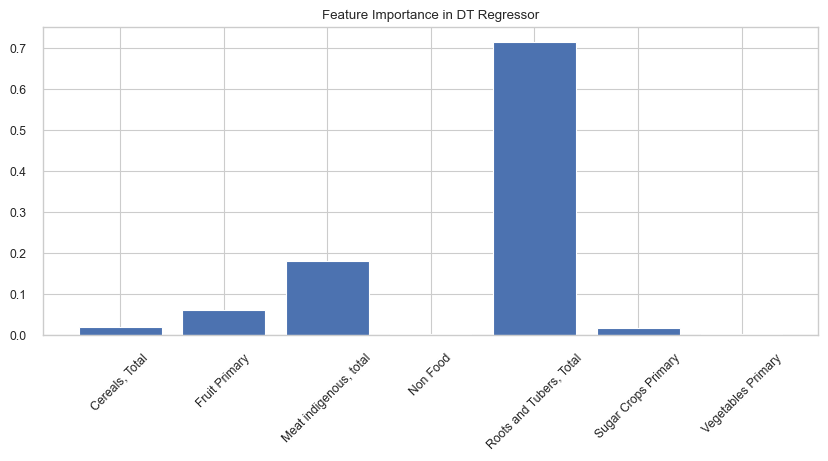

In [152]:
y_pred_DT = DTregressor.predict(X_test)
importance = DTregressor.feature_importances_
#fig, ax = plt.subplots()

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
# summarize feature importance
for i,v in enumerate(importance):
        print(X.columns[i],'Score: %.5f' % (v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
ax.set_title('Feature Importance in DT Regressor')
ax.set_xticklabels(X.columns, rotation=45)
ax.set_xticks(np.arange(len(X.columns)))
plt.show()

C:\Users\blancc2\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



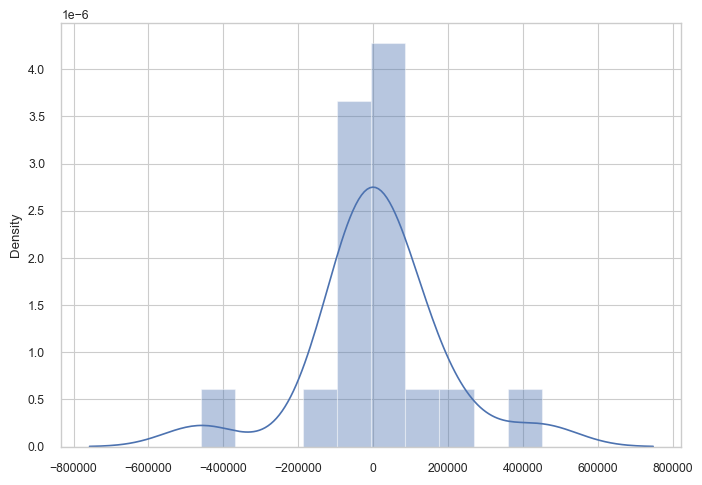

In [153]:
sns.distplot(Y_test-y_pred_DT.reshape(len(y_pred_DT),1));

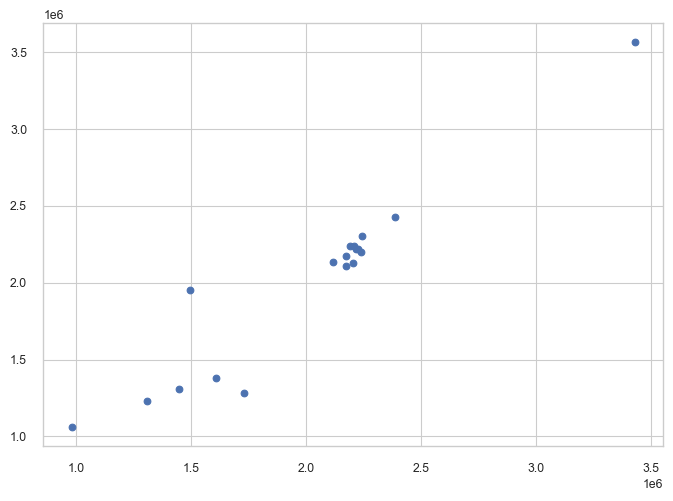

In [154]:
plt.scatter(Y_test,y_pred_DT.reshape(len(y_pred_DT),1));

In [155]:
# Hyper parameters range intialization for tuning 

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [157]:
tuning_model=GridSearchCV(DTregressor,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)

In [158]:
# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        #print(thour,":",tmin,':',round(tsec,2))

In [161]:
%%capture
from datetime import datetime

start_time=timer(None)

tuning_model.fit(X,y)

timer(start_time)

In [162]:
# best hyperparameters 
tuning_model.best_params_

{'max_depth': 11,
 'max_features': 'sqrt',
 'max_leaf_nodes': 90,
 'min_samples_leaf': 3,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [ ]:
# best model score
tuning_model.best_score_

In [ ]:
tuned_hyper_model= DecisionTreeRegressor(max_depth= 7,
 max_features= 'log2',
 max_leaf_nodes= 80,
 min_samples_leaf= 10,
 min_weight_fraction_leaf= 0.1,
 splitter='best')

In [ ]:
# fitting model


tuned_hyper_model.fit(X_train,Y_train)

In [ ]:
# prediction 

tuned_pred=tuned_hyper_model.predict(X_test)

In [ ]:
print("R-squared of the model in training set is: {}".format(tuned_hyper_model.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(tuned_hyper_model.score(X_test, tuned_pred)))

In [ ]:
plt.scatter(Y_test,tuned_pred)

In [ ]:
importance = tuned_hyper_model.feature_importances_
#fig, ax = plt.subplots()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
# summarize feature importance
for i,v in enumerate(importance):
	print(X.columns[i],'Score: %.5f' % (v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
ax.set_title('Feature Importance in DT Tuned Regressor')
ax.set_xticklabels(X.columns, rotation=45)
ax.set_xticks(np.arange(len(X.columns)))
plt.show()

In [ ]:
# With hyperparameter tuned 

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(Y_test,tuned_pred))
print('MSE:', metrics.mean_squared_error(Y_test, tuned_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, tuned_pred)))

In [ ]:
# without hyperparameter tuning 

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(Y_test,y_pred_DT))
print('MSE:', metrics.mean_squared_error(Y_test, y_pred_DT))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_DT)))

## Random Forest

In [ ]:
regressor = RandomForestRegressor(n_estimators = 4, random_state = 0)
regressor.fit(X_train, Y_train)
y_pred_random = regressor.predict(X_test)

print("R-squared of the model in training set is: {}".format(regressor.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(regressor.score(X_test, Y_test)))
print("Root mean squared error of the prediction is: {}".format((mse(Y_test, y_pred_random)**(1/2)).sum()))
print("Mean absolute percentage error of the prediction is: {}".format(smape(Y_test,y_pred_random.reshape(len(y_pred_random),1))))

In [ ]:
# Hyper parameters range intialization for tuning 

parameters={'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4]}

In [ ]:
# calculating different regression metrics

from sklearn.model_selection import GridSearchCV

In [ ]:
tuning_model_rf=GridSearchCV(RandomForestRegressor(),param_grid=parameters, return_train_score=True)

In [ ]:
# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        #print(thour,":",tmin,':',round(tsec,2))

In [ ]:
%%capture
from datetime import datetime

start_time=timer(None)

tuning_model_rf.fit(X,y)

timer(start_time)

In [ ]:
# best hyperparameters 
tuning_model_rf.best_params_

In [ ]:
# best model score
tuning_model_rf.best_score_

In [ ]:
tuned_hyper_model_rf= RandomForestRegressor(max_depth= 4, n_estimators = 250)

In [ ]:
# fitting model


tuned_hyper_model_rf.fit(X_train,Y_train)

In [ ]:
# prediction 

tuned_pred_rf=tuned_hyper_model_rf.predict(X_test)

In [ ]:
print("R-squared of the model in training set is: {}".format(tuned_hyper_model.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(tuned_hyper_model.score(X_test, tuned_pred_rf)))

In [ ]:
plt.scatter(Y_test,tuned_pred_rf)

In [ ]:
importance = tuned_hyper_model_rf.feature_importances_
#fig, ax = plt.subplots()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
# summarize feature importance
for i,v in enumerate(importance):
	print(X.columns[i],'Score: %.5f' % (v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
ax.set_title('Feature Importance in RF Tuned Regressor')
ax.set_xticklabels(X.columns, rotation=45)
ax.set_xticks(np.arange(len(X.columns)))
plt.show()

In [ ]:
# With hyperparameter tuned 

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(Y_test,tuned_pred_rf))
print('MSE:', metrics.mean_squared_error(Y_test, tuned_pred_rf))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, tuned_pred_rf)))

In [ ]:
# without hyperparameter tuning 

from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(Y_test,y_pred_random))
print('MSE:', metrics.mean_squared_error(Y_test, y_pred_random))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_random)))

## Classification

In [163]:
#Created a copy not to modify the original dataframe when running trials.
#Adding Continent?
class_df = prod19_df.copy()

In [164]:
class_df.fillna(0, inplace=True)

In [ ]:
#Onehot Encoder
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False) 
onehot = encoder.fit_transform(ml_df2[['Street_Code']])
#Convert it to df
data_hot_encoded = pd.DataFrame(onehot, index=ml_df2.index, columns=encoder.get_feature_names())

#Extract only the columns that didnt need to be encoded
data_other_cols = ml_df2.drop(columns=['Street_Code'])


#Concatenate the two dataframes : 
ml_df2 = pd.concat([data_hot_encoded, data_other_cols], axis=1)

In [ ]:
#ml_df.drop(columns='x0_nan', inplace=True) # Drop NA Surface Code column
#ml_df.drop(columns='x1_nan', inplace=True)
#ml_df.drop(columns='Rain', inplace=True)
ml_df2.drop(columns='Is_Rainy', inplace=True)

In [165]:
class_df.head()

Area  Cereals, Total  Fruit Primary  Meat indigenous, total  \
0  Afghanistan       36.263282      49.876860               30.440250   
1      Albania       49.112995     155.545650               96.876247   
2      Algeria       29.452386      85.487778               64.256817   
3       Angola       18.371780      57.580569               30.352553   
4    Argentina      399.957873     106.359028              437.902230   

   Milk, Total   Non Food  Roots and Tubers, Total  Sugar Crops Primary  \
0    24.313719   2.170455                 6.103549             0.054991   
1   167.844690  17.509759                22.699254             0.503500   
2    35.373773   3.959409                29.420493             0.000000   
3     2.807108   1.636325                54.670691             1.040472   
4    96.165605  26.035053                15.776663            18.432147   

   Vegetables Primary  cluster_no  Area Code M49 Code  iso  
0           12.133944           3        2.0     '004  AFG  
1          151.655095           5        3.0     '008  ALB  
2           73.969390           0        4.0     '012  DZA  
3            6.316054           3        7.0     '024  AGO  
4           30.400876           1        9.0     '032  ARG

In [ ]:
#DataSet In:
X=class_df.drop("cluster_no")
#DataSet Out:
y=class_df.loc[:, ['cluster_no']] # This does not make a copy (better).


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
sc = MaxAbsScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neighbors = np.arange(20, 200, 40)            # number of neighbors
train_accuracy = np.zeros(len (neighbors))    # Declare and initialise the matrix
test_accuracy = np.zeros(len(neighbors))     # Declare and initialise the matrix

In [ ]:
for i,k in enumerate(neighbors):                          # for loop that checks the model for neighbor values 1, 2, 3, ..., 9
    knn = KNeighborsClassifier(n_neighbors = k)           # Initialise an object knn using KNeighborsClassifier method

    #Fit the model
    knn.fit(X_train, Y_train)                      # Call fit method to implement the ML KNeighborsClassifier model

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, Y_train)   # Save the score value in the train_accuracy array

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, Y_test)      # Save the score value in the train_accuracy array

In [ ]:
# Delcare the size of the array
plt.figure(figsize = (8, 8))
plt.title('KNN accuracy with varying number of neighbors', fontsize = 20)
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training accuracy')
plt.legend(prop = {'size': 20})
plt.xlabel('Number of neighbors', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
# Declare and initialise an object 'KNeighborsClassifier' with 3 neighbors
knn = KNeighborsClassifier(n_neighbors = 140)

# Fit the model
knn.fit(X_train, Y_train)

prediction=knn.predict(X_test)

# Compute accuracy on the training set
train_accuracy = knn.score(X_train, Y_train)

# Compute accuracy on the test set
test_accuracy = knn.score(X_test, Y_test)

In [ ]:
train_accuracy, test_accuracy

In [ ]:
# Load the libraries for confusion matrix and for plotting of the confusion matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import itertools

# Delcare a method named as 'plot_confusion_matrix' with five arguments (cm, classes, normalize, title, cmap)
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'KNN Confusion matrix',
                          cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)     # Call imshow() for the data interpolation and color map
    plt.title(title)                                           # Assign the title
    plt.colorbar()                                             # Assign the color bar
    tick_marks = np.arange(len(classes))                       # len(classes) provides the number of classes
    plt.xticks(tick_marks, classes, rotation = 45)             # Rotation of text along the horizontal line
    plt.yticks(tick_marks, classes)  

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
class_names = ['1.0', '2.0', '3.0', '4.0']

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, prediction)

# Plot non-normalized confusion matrix
plt.figure(figsize = (6, 6))
plot_confusion_matrix(cnf_matrix, classes = class_names)
plt.title('KNN Confusion Matrix')
plt.grid(False)
plt.show()

In [ ]:
# import the library classification_report
from sklearn.metrics import classification_report

# Display the report
print(classification_report(Y_test, prediction))

## GNB

In [ ]:
# Fitting Naive Bayes Classification to the Training set with linear kernel
from sklearn.naive_bayes import GaussianNB

# Create and initialise an object sc by calling a method GaussianNB()
nvclassifier = GaussianNB()

# Train the model by calling a method fit()
nvclassifier.fit(X_train, Y_train)
prediction=nvclassifier.predict(X_test)

# Compute accuracy on the training set
train_accuracy = nvclassifier.score(X_train, Y_train)

# Compute accuracy on the test set
test_accuracy = nvclassifier.score(X_test, Y_test)

In [ ]:
train_accuracy, test_accuracy

In [ ]:
# Load the libraries for confusion matrix and for plotting of the confusion matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import itertools

# Delcare a method named as 'plot_confusion_matrix' with five arguments (cm, classes, normalize, title, cmap)
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'GNB Confusion matrix',
                          cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)     # Call imshow() for the data interpolation and color map
    plt.title(title)                                           # Assign the title
    plt.colorbar()                                             # Assign the color bar
    tick_marks = np.arange(len(classes))                       # len(classes) provides the number of classes
    plt.xticks(tick_marks, classes, rotation = 45)             # Rotation of text along the horizontal line
    plt.yticks(tick_marks, classes)  

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
class_names = ['1.0', '2.0', '3.0', '4.0']

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, prediction)

# Plot non-normalized confusion matrix
plt.figure(figsize = (6, 6))
plot_confusion_matrix(cnf_matrix, classes = class_names)
plt.title('GNB Confusion Matrix')
plt.grid(False)
plt.show()